In [8]:
import os

import numpy as np

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential, Model
from IPython.display import display, HTML, clear_output

from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedKFold

# import nltk
# from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import RegexpTokenizer
# from nltk.corpus import stopwords

from matplotlib import pyplot as plt
TEXT_COLOR = "white" # 'white' 'black'
BG_COLOR = "#111" 
plt.rcParams['axes.facecolor'] = BG_COLOR
plt.rcParams['figure.facecolor'] = BG_COLOR
plt.rcParams['text.color'] = TEXT_COLOR
plt.rcParams['axes.labelcolor'] = TEXT_COLOR
plt.rcParams['xtick.color'] = TEXT_COLOR
plt.rcParams['ytick.color'] = TEXT_COLOR

# TODO https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293

In [9]:

# TODO :
# faire une base d'evaluation en plus de train et test
# implementer un systeme d'epoch complet avec tf.dataset
# ajouter les données non supervisées au discriminateur => extraction des feature des texte non labelisé à faire
# annulation de la loss du label parametrable (lors de l'utilisation des data non supervisé), faisable en ajoutant des boolean au discriminateur faisant office de mask
# Masking loss : https://stackoverflow.com/questions/64130293/custom-loss-function-in-keras-with-masking-array-as-input

#multi output loss https://datascience.stackexchange.com/questions/86700/custom-loss-function-with-multiple-outputs-in-tensorflow

# https://ledatascientist.com/analyse-de-sentiments-avec-camembert/
# https://ledatascientist.com/introduction-a-la-categorisation-de-textes/
# https://www.kaggle.com/houssemayed/camembert-for-french-tweets-classification
# https://lbourdois.github.io/blog/nlp/BERT/


# I. Preparation des données

## A. Features extraction

In [10]:
from transformers import TFCamembertModel, CamembertTokenizer, CamembertConfig
# config = CamembertConfig.from_pretrained("camembert-base", output_hidden_states=False)
# camembert = TFCamembertModel.from_pretrained("camembert-base", config=config)
refaire_extraction = False
if(refaire_extraction):

	camembert = TFCamembertModel.from_pretrained("camembert-base")
	tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

	class CustomCamemBERT(tf.keras.Model):
		def __init__(self, camembert, tokenizer):
			super().__init__()
			self.tokenizer = tokenizer
			self.cam = camembert
			self.GAP = GlobalAveragePooling1D()
			# self.GAP = Flatten()

		def call(self, inputs):
			l = tf.reshape(tf.convert_to_tensor(()), (0, 768 * 1))
			for sentence in inputs:
				# print("\nSentence:", sentence)
				tokenized = tokenizer.tokenize(sentence)
				# print(tokenized)
				encoded = tokenizer.encode(tokenized)
				# print(encoded)
				# print(tokenizer.decode(encoded))
				encoded_sentence = tf.constant([encoded], dtype=tf.int32)
				# print("Sentence encoded:", encoded_sentence.numpy())
				x = self.cam(encoded_sentence).last_hidden_state
				# print(x.shape)
				x = x[:,0,:]
				#x = self.GAP(x)
				# x = tf.reduce_mean(x, axis=1)
				# print("x", x)
				l = tf.concat([l, x], 0)
			# print("l", l)
			return l

	# tokenized_sentence = tokenizer.tokenize("J'aime le camembert !")
	# encoded_sentence = tf.constant([tokenizer.encode(tokenizer.tokenize("J'aime le camembert !"))], dtype=tf.int32)
	# print(encoded_sentence)
	# camembert(encoded_sentence)

	NLP_model = CustomCamemBERT(camembert, tokenizer)
	NLP_model.trainable = False

	# display(model("J'aime le camembert !"))
	features = NLP_model(["J'adore le camembert", "J'aime le camembert", "J'aime pas le camembert", "Je déteste le camembert"])
	# features = NLP_model(["femme", "homme", "roi", "renne"])
	# features = features.numpy()
	# display(features)
	# features.shape
	# for i in range(len(features)):
	# 	display(np.sqrt(np.sum((features[1] - features[i]) ** 2)))

	np.sqrt(np.sum((features[:, np.newaxis, :] - features[np.newaxis, :, :]) ** 2, axis = -1))
	# TODO : tester le distance de ces deux vecteurs avec 2 autre "je deteste le camenbert" et "j'adore le camenbert"

In [11]:
if(os.path.isfile('./featured.csv')):
	sup = np.genfromtxt('featured.csv', delimiter=',')
	print(np.unique(sup[:, :1], return_counts=True))
	
else:
	sup = pd.read_csv("./supervise.csv")[["text", "label_shufan"]]
	features = NLP_model(sup[["text"]].to_numpy().reshape(-1,).tolist())
	features = features.numpy()
	labels = np.array([sup["label_shufan"]]).T
	sup = np.concatenate([labels, features], axis=1)
	np.savetxt('featured.csv', sup, delimiter=",")

	moresup = pd.read_csv("./newdata.csv")[["text", "Classification"]]
	mapping = {'observation':1, 'information':0, 'hors sujet':0, 'pub':0}
	moresup[["Classification"]] = moresup[["Classification"]].applymap(lambda s: mapping.get(s) if s in mapping else s)
	features = NLP_model(moresup[["text"]].to_numpy().reshape(-1,).tolist())
	features = features.numpy()
	labels = moresup[["Classification"]].values
	moresup = np.concatenate([labels, features], axis=1)

	allsup = np.concatenate([sup, moresup])

if(os.path.isfile('./nonsup_features.csv')):
	nonsup = pd.read_csv("./nonsup_features.csv").values
else:
	nonsup = pd.read_csv("./nonsupervise.csv")[0:5000]
	nonsup = NLP_model(nonsup.to_numpy().reshape(-1,).tolist())
	np.savetxt('./nonsup_features.csv', nonsup, delimiter=",")

# diff = abs(np.std(sup[:,1:], axis=0) - np.std(nonsup[:], axis=0))
# print(np.mean(diff), np.std(diff))
# plt.figure(figsize=(16*2, 9), dpi=120)
# plt.bar(x=range(len(diff)), height=diff)
# plt.show()


(array([0., 1.]), array([566,  71], dtype=int64))


## B. Split train / test (cf schema)

In [12]:
# y_sup, x_sup = sup[:,:1], sup[:,1:]
# x_sup = (x_sup - x_sup.min()) / (x_sup.max() - x_sup.min())
# sup = np.concatenate([y_sup, x_sup], axis=1)
_, c = np.unique(sup[:, 0], return_counts=True)
nb_observations = c[1]
sup_train = np.concatenate([sup[sup[:,0] == 1][:], sup[sup[:,0] == 0][0:nb_observations]])
sup_test_surplus = sup[sup[:,0] == 0][nb_observations:]
sup_train[:,0]

def odd_distribution(data):
	A, B = data[data[:, 0] == 1], data[data[:, 0] == 0]
	C = [None]*(len(A)+len(B))
	C[::2] = A
	C[1::2] = B
	return np.array(C)

sup_train = odd_distribution(sup_train)
taux_labellise = 0.05
# nonsup = (nonsup - nonsup.min()) / (nonsup.max() - nonsup.min())
nonsup_utilise = nonsup[0:round(len(sup_train) / taux_labellise)]
y_nonsup = np.ones((len(nonsup_utilise), 1))
nonsup_dataset = tf.data.Dataset.from_tensor_slices((nonsup_utilise,  y_nonsup))
# nonsup_dataset = nonsup_dataset.shuffle(buffer_size=2048).repeat(2).batch(25)
n_batch_nonsup = 32
nonsup_dataset = nonsup_dataset.shuffle(buffer_size=1024).batch(n_batch_nonsup)
# for step, (x_batch_train, y_batch_train) in enumerate(nonsup_dataset):
# 	print(step, np.mean(x_batch_train), y_batch_train.shape)

sup_train[:,0]
display(len(y_nonsup), len(sup_train), str((len(sup_train) * 100) / len(y_nonsup)) + "%")

2840

142

'5.0%'

# II. Preparations des modèles

In [13]:
latent_dim = 100

def generate_noise(n_batch, latent_dim=100):
    return np.random.randn(latent_dim * n_batch).reshape((n_batch, latent_dim))

def generate_fake_samples(n_batch, labelN, generator):
	labels = np.repeat(labelN, n_batch)
	X_fake = generator.predict([generate_noise(n_batch, generator.inputs[0].shape[1]), labels])
	# X_fake = generator([generate_noise(n_batch, generator.inputs[0].shape[1]), labels], training = True)
	y_fake = [labels, np.repeat(0, n_batch)]
	return X_fake, y_fake

def select_real_samples(n_batch, labelN, dataset):
	dataset = dataset[dataset[:, 0] == labelN, :]
	ind = np.random.choice(len(dataset), size=n_batch, replace=False)
	labels = np.repeat(labelN, n_batch)
	X_real = np.array(dataset[ind, 1:].tolist())
	y_real =  [labels, np.repeat(1, n_batch)]
	return X_real, y_real

def train_d(discriminator, discriminator_R_only, dataset, dataset_nonsup, n_batch, force_bruit=0.001):
	# (n_batch, 768), ([label, validité])
	# X_real, y_real = select_real_samples(n_batch, 0, dataset=dataset)
	# d_real_0 = discriminator.train_on_batch(X_real, y_real)

	# X_real, y_real = select_real_samples(n_batch, 1, dataset=dataset)
	# d_real_1 = discriminator.train_on_batch(X_real, y_real)
	d_real = []
	d_fake0 = []
	d_fake1 = []
	d_nonsup_r = []
	step_sup_total = 0
	step_ssup_total = 0
	nb_back = 0
	for step, (x_batch_train, y_batch_train) in enumerate(dataset):
		# print(x_batch_train.shape, y_batch_train.shape)

		# entrainement sur données labellisée reels
		d_real.append(discriminator.train_on_batch(x_batch_train, y_batch_train)) # 1s 
		
		# entrainement sur données labellisée générées (0)
		X_fake, y_fake = generate_fake_samples(n_batch // 2, 0, generator=G) # 0.5s
		d_fake0.append(discriminator.train_on_batch(X_fake, y_fake))
		
		# entrainement sur données labellisée générées (1)
		X_fake, y_fake = generate_fake_samples(n_batch // 2, 1, generator=G) # 0.5s
		d_fake1.append(discriminator.train_on_batch(X_fake, y_fake))

		
	# for step, (x_batch_train, y_batch_train) in enumerate(dataset_nonsup):
	# 	# entrainement sur données non labellisée => uniquement prediction de la réalité de la donnée
	# 	d_nonsup_r.append(discriminator_R_only.train_on_batch(x_batch_train, y_batch_train)) # 1ns

	# 	# entrainement sur données labellisée générées (0)
	# 	X_fake, y_fake = generate_fake_samples(n_batch_nonsup // 2, 0, generator=G) # 0.5ns
	# 	d_fake0.append(discriminator.train_on_batch(X_fake, y_fake))
		
	# 	# entrainement sur données labellisée générées (1)
	# 	X_fake, y_fake = generate_fake_samples(n_batch_nonsup // 2, 1, generator=G) # 0.5ns => total 2s + 2ns
	# 	d_fake1.append(discriminator.train_on_batch(X_fake, y_fake))
		
	
	# loss, label_loss, reality_loss (loss est la loss du model utilisé pour l'entrainement = label_loss + reality_loss)
	d_real = np.mean(d_real, axis=0)
	d_fake0 = np.mean(d_fake0, axis=0)
	d_fake1 = np.mean(d_fake1, axis=0)
	d_nonsup_r = np.mean(d_nonsup_r)
	losses = np.concatenate([[d_real], [d_fake0], [d_fake1]], axis=0)
	losses = np.mean(losses, axis=0)
	return losses, d_nonsup_r

def train_g(gan, n_batch, step=1, force_bruit=0.0):
	# TODO reverifier comment ajouter du bruit : accuracy à 0 si force_bruit != 0 actuellement, sans doute pas possibilité de bce mais mse ok
	reality = np.repeat(0, n_batch) + np.random.rand(n_batch) * force_bruit # ajout de bruit
	g_loss_1 = []
	g_loss_0 = []
	return_dict = False
	nb_back = 0
	for s in range(step):
		labels = np.repeat(1, n_batch) - np.random.rand(n_batch) * force_bruit # ajout de bruit
		noise = generate_noise(n_batch, latent_dim)
		g_loss_1.append(gan.train_on_batch([noise, labels], [labels, reality], return_dict=return_dict)) # 1 n_batch

		labels = np.repeat(0, n_batch) + np.random.rand(n_batch) * force_bruit # ajout de bruit
		noise = generate_noise(n_batch, latent_dim)
		g_loss_0.append(gan.train_on_batch([noise, labels], [labels, reality], return_dict=return_dict)) # 1 n_batch => total = step * 2 n_batch
		nb_back += n_batch + n_batch
	print("G nb_back ", nb_back)
	# loss, label_loss, reality_loss (loss est la loss du model utilisé pour l'entrainement = label_loss + reality_loss)
	g_loss_1 = np.mean(g_loss_1, axis=0) # possibilité d'avoir l'erreur par type de label pour voir si le G performe mieux sur un label plutôt qu'un autre, ici je moyenne le cas 1 et 0
	g_loss_0 = np.mean(g_loss_0, axis=0)
	# print(g_loss_1, "\n", g_loss_0)
	losses = np.concatenate([[g_loss_1], [g_loss_0]], axis=0)
	losses = np.mean(losses, axis=0)
	return losses

# def train_GAN(gan, discriminator, discriminator_R_only, dataset, dataset_nonsup, n_batch, train_gan=True, force_bruit=0.001):
	
# 	d_real = []
# 	d_fake = []
# 	d_fake0 = []
# 	d_fake1 = []
# 	d_nonsup_r = []
# 	g_loss = []

# 	for step, (x_batch_train, y_batch_train) in enumerate(dataset):
# 		# entrainement de D sur données labellisée reels
# 		d_real.append(discriminator.train_on_batch(x_batch_train, y_batch_train)) # 1s
# 		if(train_gan):
# 			# Entrainement de G sur autant de donnée
# 			n_b = len(x_batch_train)
# 			reality = np.repeat(0, n_b)
# 			noise, labels = generate_noise(n_b, latent_dim), np.random.randint(0, 2, n_b)
# 			g_loss.append(gan.train_on_batch([noise, labels], [labels, reality]))
			
# 			# gx = G.predict([noise, labels])
# 			# d_fake.append(discriminator.predict(gx, [labels, reality]))
# 			# g_loss.append(gan.predict([noise, labels], [labels, reality]))

# 		# entrainement sur données labellisée générées (0)
# 		X_fake, y_fake = generate_fake_samples(n_batch // 2, 0, generator=G) # 0.5s
# 		# y_pred = discriminator.predict(X_fake)
# 		e = discriminator.train_on_batch(X_fake, y_fake)
# 		# print(np.array(y_fake).reshape(-1, 2), np.array(y_pred).reshape(-1, 2))
# 		d_fake0.append(e)
# 		# print(e)
		
# 		if(train_gan):
# 			# Entrainement de G sur autant de donnée
# 			reality = np.repeat(0,  n_batch // 2)
# 			noise, labels = generate_noise(n_batch // 2, latent_dim), np.repeat(0, n_batch // 2) # - np.random.rand(n_batch // 2) * force_bruit # ajout de bruit
# 			g_loss.append(gan.train_on_batch([noise, labels], [labels, reality]))
		
# 		# entrainement sur données labellisée générées (1)
# 		X_fake, y_fake = generate_fake_samples(n_batch // 2, 1, generator=G) # 0.5s
# 		d_fake1.append(discriminator.train_on_batch(X_fake, y_fake))
# 		if(train_gan):
# 			# Entrainement de G sur autant de donnée
# 			noise, labels = generate_noise(n_batch // 2, latent_dim), np.repeat(1, n_batch // 2) # - np.random.rand(n_batch // 2) * force_bruit # ajout de bruit
# 			g_loss.append(gan.train_on_batch([noise, labels], [labels, reality]))

# 	d_nonsup_r = [0]
# 	# for step, (x_batch_train, y_batch_train) in enumerate(dataset_nonsup):
# 	# 	# entrainement sur données non labellisée => uniquement prediction de la réalité de la donnée
# 	# 	d_nonsup_r.append(discriminator_R_only.train_on_batch(x_batch_train, y_batch_train)) # 1ns
# 	# 	if(train_gan):
# 	# 		# G
# 	# 		n_b = len(x_batch_train)
# 	# 		reality = np.repeat(0, n_b)
# 	# 		noise, labels =  generate_noise(n_b, latent_dim), np.random.randint(0, 2, n_b)
# 	# 		g_loss.append(gan.train_on_batch([noise, labels], [labels, reality]))		
	
# 	# loss, label_loss, reality_loss (loss est la loss du model utilisé pour l'entrainement = label_loss + reality_loss)
# 	d_real = np.mean(d_real, axis=0)
# 	d_fake0 = np.mean(d_fake0, axis=0)
# 	d_fake1 = np.mean(d_fake1, axis=0)
# 	if(train_gan):
# 		g_loss = np.mean(g_loss, axis=0)
# 	else:
# 		g_loss = 0
# 	d_nonsup_r = np.mean(d_nonsup_r)
# 	losses = np.concatenate([[d_real], [d_fake0], [d_fake1]], axis=0)
# 	losses = np.mean(losses, axis=0)
# 	return losses, d_nonsup_r, g_loss

def train_GAN(gan, discriminator, discriminator_R_only, dataset, dataset_nonsup, n_batch, train_gan=True, force_bruit=0.001):
	
	d_real = []
	d_fake = []
	d_fake = []
	d_nonsup_r = []
	g_loss = []

	for step, (x_batch_train, y_batch_train) in enumerate(dataset):
		
		if(train_gan):
			n_batch = len(x_batch_train)
			# Entrainement de G sur autant de donnée
			reality, noise, labels = np.repeat(0, n_batch), generate_noise(n_batch, latent_dim), np.random.randint(0, 2, n_batch)
			gx = G.predict([noise, labels])
			d_fake.append(discriminator.train_on_batch(gx, [labels, reality]))
			g_loss.append(gan.train_on_batch([noise, labels], [labels, reality]))
			
		# entrainement de D sur données labellisée reels
		d_real.append(discriminator.train_on_batch(x_batch_train, y_batch_train)) # 1s

	d_nonsup_r = [0]
	
	# loss, label_loss, reality_loss (loss est la loss du model utilisé pour l'entrainement = label_loss + reality_loss)
	d_real = np.mean(d_real, axis=0)
	d_fake = np.mean(d_fake, axis=0)
	if(train_gan):
		g_loss = np.mean(g_loss, axis=0)
	else:
		g_loss = 0
	d_nonsup_r = np.mean(d_nonsup_r)
	losses = np.concatenate([[d_real], [d_fake]], axis=0)
	losses = np.mean(losses, axis=0)
	return losses, d_nonsup_r, g_loss

In [14]:
# k_fold = StratifiedKFold(n_splits=5)
# X, y = sup_train[:, 1:], sup_train[:, :1]
# for step, (train_index, test_index) in enumerate(k_fold.split(X, y)):
# 	# print('\nTrain: %s | test: %s' % (train_index.shape, test_index.shape))

# 	(D, D_R_only, D_L_only, (extractor, predictor)), G, GAN = creation_models(competition=competition, lrs=(D_lr, G_lr)) # Remise à 0 des models à chaque fold

	
# 	test = np.concatenate([y[test_index], X[test_index]], axis=1)
# 	test = np.concatenate([test, sup_test_surplus], axis=0) # ajout du surplus de non observations

# 	x_test, y_test = test[:, 1:], test[:, :1]
# 	x_train, y_train = X[train_index], y[train_index]

# 	train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# 	train_dataset = train_dataset.batch(n_batch)

# 	nonsup_utilise = nonsup[0:round(len(sup_train) / 0.25)]
# 	y_nonsup = np.ones((len(nonsup_utilise), 1))
# 	nonsup_dataset = tf.data.Dataset.from_tensor_slices((nonsup_utilise,  y_nonsup))
# 	n_batch_nonsup = 32
# 	n_batch = 32
# 	nonsup_dataset = nonsup_dataset.shuffle(buffer_size=1024).batch(n_batch_nonsup)


# 	train_d(D, D_R_only, train_dataset, nonsup_dataset, n_batch)
# 	train_g(GAN, n_batch, step=len(train_dataset) + len(nonsup_dataset)) # 

In [15]:
tf.config.run_functions_eagerly(False)
# tf.data.experimental.enable_debug_mode()

def accuracy(flip: bool = False): 
	""" Genere les fonctions de metriques de precision pour les modèles GAN et D """
	if flip:
		def acc(y_true, y_pred):
			# print(flip, y_true.shape, y_pred.shape, (1 - y_pred).shape)
			return tf.keras.metrics.binary_accuracy(tf.round(y_true), 1 - y_pred)
	else:
		def acc(y_true, y_pred):
			# print(flip, y_true.shape, y_pred.shape, (1 - y_pred).shape)
			return tf.keras.metrics.binary_accuracy(tf.round(y_true), y_pred)
	return acc

"""
Cooeficient qui determine l'importance d'une prediction plutot qu'une autre (à traiter comme un meta-parametre)
K pondere l'erreur lié à la prediction de la realité de la donnée
1 - K pondere l'erreur lié à la prediction du label
"""

# tf.keras.losses.binary_crossentropy # losses.mean_squared_error
K = 0.5 # TODO tester ce meta praremetre lorrs des phases d'evaluation
def reality_loss(flip: bool = False, k: float = K): 
	if flip:
		def f(y_true, y_pred): return tf.keras.losses.binary_crossentropy(y_true, 1 - y_pred) # (1 - k) * tf.keras.losses.binary_crossentropy(y_true, 1 - y_pred)
		# def f(y_true, y_pred): return (1 - k) * tf.losses.mean_squared_error(y_true, 1 - y_pred)
	else:
		def f(y_true, y_pred): return tf.keras.losses.binary_crossentropy(y_true, y_pred) # (1 - k) * tf.keras.losses.binary_crossentropy(y_true, y_pred)
		# def f(y_true, y_pred): return (1 - k) * tf.losses.mean_squared_error(y_true, y_pred)
	return f

def label_loss(flip: bool = False, k: float = K):
	if flip:
		def f(y_true, y_pred): return tf.keras.losses.binary_crossentropy(y_true, 1 - y_pred) #k * tf.keras.losses.binary_crossentropy(y_true, 1 - y_pred)
		# def f(y_true, y_pred): return k * tf.losses.mean_squared_error(y_true, 1 - y_pred)
	else:
		def f(y_true, y_pred): return k * tf.keras.losses.binary_crossentropy(y_true, y_pred) # k * tf.keras.losses.binary_crossentropy(y_true, y_pred)
		# def f(y_true, y_pred): return k * tf.losses.mean_squared_error(y_true, y_pred)
	return f

def f1_score(precision, recall):
	return 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
	
# @tf.function
# def discriminator_realityloss(y_true, y_pred):
# 	return reality_loss(y_true, y_pred)
# => reality_loss(flip = false)

def APS(y_true, y_pred):
	return average_precision_score(y_true, y_pred)

def top_bottom_std(d):
	data = np.array(d)
	data_means = np.mean(data, axis=0)
	data = np.where(data_means < data, np.ma.array(data, mask=data_means < data).mean(axis=0), data)
	std_bottom = np.std(data, axis=0)

	data = d
	data_means = np.mean(data, axis=0)
	data = np.where(data_means > data, np.ma.array(data, mask=data_means > data).mean(axis=0), data)
	std_top = np.std(data, axis=0)

	return data_means, std_bottom, std_top

# III. Definition des modèles

In [73]:
from tensorflow.keras import backend as K

def PermaDropout(rate):
    return Lambda(lambda x: K.dropout(x, level=rate))

from tensorflow.keras.initializers import RandomNormal
# seed = 666
# D_output_initializers_W = tf.keras.initializers.RandomNormal(mean=0.5, stddev=0.1, seed=seed)
# D_output_initializers_B = tf.keras.initializers.RandomNormal(mean=0.5, stddev=0.1, seed=seed)
init = RandomNormal(mean=0.0, stddev=0.02)

def generator(latent_dim):

	noise = Input(shape=(latent_dim,), name="noise_input", dtype=tf.float32)
	label = Input(shape=(1,), name="label_input", dtype=tf.float32) 
	
	a = LeakyReLU(0.2)(BatchNormalization()(Dense(32)(noise)))
	
	b = Flatten()(Embedding(2, latent_dim, name="label_embeding")(label))
	b = LeakyReLU(0.2)(BatchNormalization()(Dense(32)(b)))

	x = LeakyReLU(0.2)(BatchNormalization()(Multiply(name="Combine_Inputs_Branches")([a, b])))
	# x = Concatenate(name="Combine_Inputs_Branches")([a, b])
	# x = PermaDropout(0.5)(x)

	x = LeakyReLU(0.2)(BatchNormalization()(Dense(64)(x)))
	x = PermaDropout(0.5)(x)
	x = LeakyReLU(0.2)(BatchNormalization()(Dense(128)(x)))
	x = PermaDropout(0.5)(x)
	x = LeakyReLU(0.2)(BatchNormalization()(Dense(256)(x)))
	x = PermaDropout(0.5)(x)

	# out = Dense(768, kernel_initializer=RandomNormal(mean=np.mean(np.mean(sup[:,1:], axis=0)), stddev=np.std(np.mean(sup[:,1:], axis=0))), name="Generated_Hidden_rep")(x) # initialisation pour un output "proche" des donné reel
	out = Dense(768, kernel_initializer=RandomNormal(mean=0.0, stddev=0.25), name="Generated_Hidden_rep")(x) # initialisation pour un output "proche" des donné reel
	# out = Dense(768, kernel_initializer=init, name="Generated_Hidden_rep")(x)
	return Model([noise, label], out, name="Generator")

def discriminator():

	hidden_rep = Input(shape=(768,), name="Hidden_rep_Input")

	x = LayerNormalization()(hidden_rep)
	x = LeakyReLU(0.2)(BatchNormalization()(Dense(512)(x)))
	# x = Dropout(0.2)(x)
	x = LeakyReLU(0.2)(BatchNormalization()(Dense(256)(x)))
	# x = Dropout(0.2)(x)
	x = LeakyReLU(0.2)(BatchNormalization()(Dense(128)(x)))
	# x = Dropout(0.2)(x)
	
	Rout = Dense(1, activation="sigmoid", name="Reality",)(x)    
	Lout = Dense(1, activation="sigmoid", name="Label",  )(x)    

	return Model(hidden_rep, [Lout, Rout], name="Discriminator"), Model(hidden_rep, Rout, name="Discriminator"), Model(hidden_rep, Lout, name="Discriminator") # https://stackoverflow.com/questions/48335212/how-to-prevent-backpropagation-after-compiling-a-keras-model


In [74]:
def creation_models(competition=True, lrs=(0.0002, 0.0002), latent_dim=100):
	dlr, glr = lrs
	D, D_R_only, D_L_only = discriminator()
	# D_GAN_optimizer = tf.keras.optimizers.Adam(learning_rate=dlr)
	# D.compile(loss={"Label":label_loss(flip = False), "Reality":reality_loss(flip = False)}, optimizer=D_GAN_optimizer)
	D.compile(
		loss    = { "Label": label_loss(flip = False), "Reality": reality_loss(flip = False) },
		metrics = { "Label": accuracy(flip = False),   "Reality": accuracy(flip = False)     },
		optimizer = tf.keras.optimizers.Adam(learning_rate=dlr)
	)
	D_R_only.compile(loss=reality_loss(flip = False), optimizer = tf.keras.optimizers.Adam(learning_rate=dlr))
	D_L_only.compile(loss=label_loss(flip = False), optimizer=tf.keras.optimizers.Adam(learning_rate=dlr))
	D.trainable = False

	G = generator(latent_dim)
	G.compile()

	noise = Input(shape=(latent_dim,), name="GAN_input_noise")
	label = Input(shape=(1,), name="GAN_input_label")
	hidden_rep = G([noise, label])
	validity = D(hidden_rep)
	out0 = Lambda(lambda x: x, name="Label")(validity[0]) # juste pour le renomage des layers (sinon nom par defaut {Discriminator, Discriminator_1} bug tf ?)
	out1 = Lambda(lambda x: x, name="Reality")(validity[1])

	GAN = Model(inputs=[noise, label], outputs=[out0, out1], name="GAN")
	# GAN.trainable = False
	# cooperatif ou competition : 
	# GAN.compile( loss = {"Label": label_loss(flip = competition), "Reality": reality_loss(flip = True)}, optimizer = tf.keras.optimizers.Adam(learning_rate=glr))
	# GAN.trainable = False
	GAN.compile(
		loss    = { "Label": label_loss(flip = competition), "Reality": reality_loss(flip = True) },
		metrics = { "Label": accuracy(flip = competition),   "Reality": accuracy(flip = True)     },
		optimizer = tf.keras.optimizers.Adam(learning_rate=glr)
	)

	extractor = tf.keras.Model(inputs=D.inputs, outputs=D.layers[-3].output)
	extractor.trainable = False
	predictor = tf.keras.Model(inputs=extractor.output, outputs=D.output)
	predictor.trainable = False
	
	return (D, D_R_only, D_L_only, (extractor, predictor)), G, GAN


(D, D_R_only, D_L_only, (extractor, predictor)), G, GAN = creation_models(competition=True)

# Faire une prediction pour activer les metrics
n_predict = 10
reality = np.repeat(0, n_predict)
labels = np.repeat(1, n_predict)
noise = generate_noise(n_predict, latent_dim)
gx = G.predict([noise, labels])
D.evaluate(gx, [labels, reality])
display(np.unique(np.round(D.predict(gx), 0)[0], return_counts=True))
display(np.unique(np.round(D.predict(gx), 0)[1], return_counts=True))
display()
GAN.evaluate([noise, labels], [labels, reality])
display(np.unique(np.round(GAN.predict([noise, labels]), 0)[0], return_counts=True))
display(np.unique(np.round(GAN.predict([noise, labels]), 0)[1], return_counts=True))

display(tf.keras.metrics.binary_accuracy(reality, GAN.predict([noise, labels])[1].reshape(-1,)))

D_metrics = ['D_'+m for m in D.metrics_names]
G_metrics = ['G_'+m for m in GAN.metrics_names]
# display()
# display("D metrics = " + str(D_metrics))
# display("G metrics = " + str(G_metrics))
# display()
# display(D.summary())
# display(G.summary())



1/1 [==============================] - 1s 723ms/step - loss: 1.0043 - Label_loss: 0.4055 - Reality_loss: 0.5988 - Label_acc: 0.2000 - Reality_acc: 0.8000


(array([0., 1.], dtype=float32), array([8, 2], dtype=int64))

(array([0., 1.], dtype=float32), array([8, 2], dtype=int64))

1/1 [==============================] - 1s 899ms/step - loss: 1.4398 - Label_loss: 0.6513 - Reality_loss: 0.7885 - Label_acc: 0.7000 - Reality_acc: 0.3000


(array([0., 1.], dtype=float32), array([8, 2], dtype=int64))

(array([0., 1.], dtype=float32), array([7, 3], dtype=int64))

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [75]:
GAN.summary()

Model: "GAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 GAN_input_noise (InputLayer)   [(None, 100)]        0           []                               
                                                                                                  
 GAN_input_label (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 Generator (Functional)         (None, 768)          249672      ['GAN_input_noise[0][0]',        
                                                                  'GAN_input_label[0][0]']        
                                                                                                  
 Discriminator (Functional)     [(None, 1),          563330      ['Generator[0][0]']            

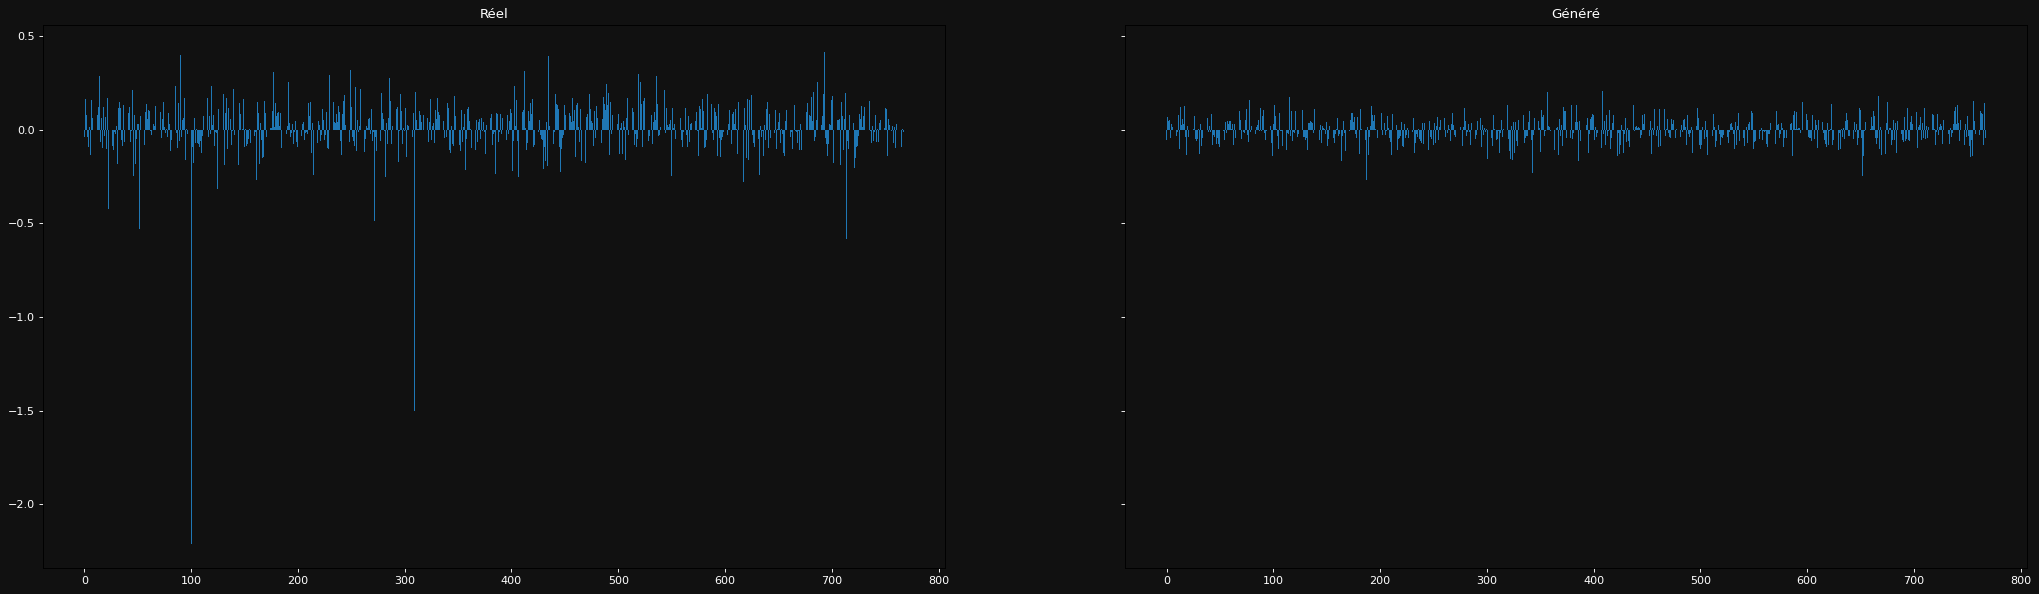

In [76]:
l = np.repeat(1, 1)
n = generate_noise(1, latent_dim)
pred_avant = G.predict([n, l])

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16*2, 9), dpi=80)
axs[0].bar(range(768), sup[24,1:])
axs[0].set(title='Réel')
axs[1].bar(range(768), pred_avant[0])
axs[1].set(title='Généré')
plt.show()

In [20]:
# l = np.tile([0, 1], int(244 / 2)).reshape((-1, 1))
# n = generate_noise(244, latent_dim)
# f2d = np.expand_dims(extractor.predict(G.predict([n, l])), axis=0)
# r2d_train = np.expand_dims(extractor.predict(sup_train[:,1:]), axis=0)
# r2d_test = np.expand_dims(extractor.predict(sup_test[:,1:]), axis=0)
# # add reality
# freality = np.repeat(0, np.prod(f2d.shape) / 2).reshape((f2d.shape[0], f2d.shape[1], 1))
# train_reality = np.repeat(1, np.prod(r2d_train.shape) / 2).reshape((r2d_train.shape[0], r2d_train.shape[1], 1))
# test_reality = np.repeat(1, np.prod(r2d_test.shape) / 2).reshape((r2d_test.shape[0], r2d_test.shape[1], 1))
# # add label
# flabel = l.reshape((f2d.shape[0], f2d.shape[1], 1))
# train_label = sup_train[:,0].reshape((1, sup_train.shape[0], 1))
# test_label = sup_test[:,0].reshape((1, sup_test.shape[0], 1))
# # add predicction [plabel, preality]
# f2d_pred = predictor.predict(f2d[0])
# train_pred = predictor.predict(r2d_train[0])
# test_pred = predictor.predict(r2d_test[0])
# # alpha
# fa = np.repeat(1, np.prod(f2d.shape) / 2).reshape((f2d.shape[0], f2d.shape[1], 1))
# train_a = np.repeat(0.25, np.prod(r2d_train.shape) / 2).reshape((r2d_train.shape[0], r2d_train.shape[1], 1))
# test_a = np.repeat(1, np.prod(r2d_test.shape) / 2).reshape((r2d_test.shape[0], r2d_test.shape[1], 1))
# #concatenation
# fakes = np.concatenate([f2d, flabel, freality, [f2d_pred[0]], [f2d_pred[1]], fa], axis=-1)
# reels_train = np.concatenate([r2d_train, train_label, train_reality, [train_pred[0]], [train_pred[1]], train_a], axis=-1)
# reels_test = np.concatenate([r2d_test, test_label, test_reality, [test_pred[0]], [test_pred[1]], test_a], axis=-1)

# data = np.concatenate([fakes, reels_train, reels_test], axis=1)
# data[0,0].tolist()
# # 0 = x
# # 1 = y
# # 2 = true_label
# # 3 = true_reality
# # 4 = pred_label
# # 5 = pred_reality
# # 6 = alpha
# plt.figure(figsize=(16, 9), dpi=80)
# MapColor = np.array(['r', 'g'])
# MapEdgecolor = np.array(['r', 'g'])
# MapMarkers = np.array(['o', 's'])
# s = 75
# es = 125 / s
# for _, m in enumerate(np.unique(data[0,:,2])):
# 	d = data[:,data[0,:,2] == m]
# 	plt.scatter(d[0,:,0], d[0,:,1], color=MapColor[d[0,:,3].astype(int)], edgecolor=MapEdgecolor[np.round(d[0,:,5]).astype(int)], alpha=d[0,:,6], marker=MapMarkers[int(m)], s=s + s * d[0,:,4], linewidths=es)
# # couleur centrale = realité de la donnée (vert = reel, rouge = genere)
# # couleur de la bordure = prediction de la réalité de la donnée (vert = reel, rouge = genere)
# # carré = observation
# # rond = pas une observation

# III. Entraînement Semi-Supervisé

In [79]:
mse = tf.keras.metrics.MeanSquaredError(name="mse")
bce = tf.keras.metrics.BinaryCrossentropy(name="bce")
# precision = tf.keras.metrics.Precision(thresholds=0.5, name="precision")
# recall = tf.keras.metrics.Recall(thresholds=0.5, name="recall")
AUC = tf.keras.metrics.AUC(name="AUC")
# metrics = [loss, precision, recall, AUC]
metrics = [bce, mse, AUC]
train_APS, test_APS = None, None

# x_train, y_train = sup_train[:, 1:], sup_train[:, 0]
# x_test, y_test = sup_test[:, 1:], sup_test[:, 0]

thresholds = 0.5
train_gan = True
tf.config.run_functions_eagerly(False)
# tf.data.experimental.disabled_debug_mode()
training_ss_hist = []
n_Fold = 5
n_batch = 64
D_lr = 0.0002
G_lr = D_lr / 4
competition = False
epochs = 100
k_fold = StratifiedKFold(n_splits=n_Fold)
X, y = sup_train[:, 1:], sup_train[:, :1]
g_r_acc = 0
n_predict = 1000
reality, noise, labels = np.repeat(0, n_batch), generate_noise(n_batch, latent_dim), np.random.randint(0, 2, n_batch)
for step, (train_index, test_index) in enumerate(k_fold.split(X, y)):
	# print('\nTrain: %s | test: %s' % (train_index.shape, test_index.shape))

	(D, D_R_only, D_L_only, (extractor, predictor)), G, GAN = creation_models(competition=competition, lrs=(D_lr, G_lr)) # Remise à 0 des models à chaque fold

	test = np.concatenate([y[test_index], X[test_index]], axis=1)
	test = np.concatenate([test, sup_test_surplus], axis=0) # ajout du surplus de non observations

	x_test, y_test = test[:, 1:], test[:, :1]
	x_train, y_train = X[train_index], y[train_index]
	
	# print(np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True))
	# print(y_train.reshape(-1,))

	train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
	# train_dataset = train_dataset.shuffle(buffer_size=1024).batch(n_batch)
	train_dataset = train_dataset.batch(n_batch)

	
	register_every = 1
	pdhist = pd.DataFrame(columns= D_metrics + ["d_R_only_loss"] + G_metrics + ["bce", "mse", "AUC", "APS", "val_bce", "val_mse", "val_AUC", "val_APS", "DACC", "GACC"])
	hist = []
	for e in range(epochs):
		clear_output(wait=True)
		# d_loss, d_R_only_loss = train_d(D, D_R_only, train_dataset, nonsup_dataset, n_batch)
		# g_loss = train_g(GAN, n_batch, step=len(train_dataset) + len(nonsup_dataset)) # 
		# if(g_r_acc >= 0.8):
		# 	d_loss, d_R_only_loss, _ = train_GAN(GAN, D, D_R_only, train_dataset, nonsup_dataset, n_batch, train_gan=False)
		# else:
		# 	d_loss, d_R_only_loss, g_loss = train_GAN(GAN, D, D_R_only, train_dataset, nonsup_dataset, n_batch, train_gan=True)
		d_loss, d_R_only_loss, g_loss = train_GAN(GAN, D, D_R_only, train_dataset, nonsup_dataset, n_batch, train_gan=True)
		# print(g_loss, g_loss[4], g_loss[4] < 0.5)
		# if(g_loss[4] < 0.5):
		# 	G.trainable = True
		# 	GAN.compile(loss = { "Label": label_loss(flip = competition), "Reality": reality_loss(flip = True) }, metrics = { "Label": accuracy(flip = True), "Reality": accuracy(flip = True) },optimizer = tf.keras.optimizers.Adam(learning_rate=G_lr))
		# else:
		# 	G.trainable = False
		# 	GAN.compile(loss = { "Label": label_loss(flip = competition), "Reality": reality_loss(flip = True) }, metrics = { "Label": accuracy(flip = True), "Reality": accuracy(flip = True) },optimizer = tf.keras.optimizers.Adam(learning_rate=G_lr))
		
		# G.trainable = g_loss[4] < 0.5

		
		# display(D.evaluate(gx, [labels, reality], verbose=0)[-1])
		# display(np.unique(np.round(D.predict(gx), 0)[0], return_counts=True))
		# display(np.unique(np.round(D.predict(gx), 0)[1], return_counts=True))
		# display()
		gx = G.predict([noise, labels])
		d_r_acc = D.evaluate(gx, [labels, reality], verbose=0)[-1]
		g_r_acc = GAN.evaluate([noise, labels], [labels, reality], verbose=0)[-1]
		# display(d_r_acc, g_r_acc)
		# display(np.unique(np.round(GAN.predict([noise, labels]), 0)[0], return_counts=True))
		# display(np.unique(np.round(GAN.predict([noise, labels]), 0)[1], return_counts=True))

		if(e % register_every == 0):
			y_pred_score = D.predict(x_train)[0].reshape(-1, )
			# y_pred = np.where(y_pred_score > thresholds, 1, 0)
			[metric.update_state(y_train, y_pred_score) for metric in metrics] # update
			train_metrics = [metric.result().numpy() for metric in metrics] # result
			[metric.reset_states() for metric in metrics] # reset
			train_APS = APS(y_train, y_pred_score)

			y_pred_score = D.predict(x_test)[0].reshape(-1, )
			# y_pred = np.where(y_pred_score > thresholds, 1, 0)
			[metric.update_state(y_test, y_pred_score) for metric in metrics] # update
			test_metrics = [metric.result().numpy() for metric in metrics] # result
			[metric.reset_states() for metric in metrics] # reset
			test_APS = APS(y_test, y_pred_score)
				
			# confusion_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
			# print(f"""
			# Precision: 	{precision}
			# Recall: 	{recall}
			# f1_score: 	{f1}
			# AUC: 		{AUC}
			# Matrice de confusion:\n{confusion_matrix}
			# """)

			"""
			f2d = np.expand_dims(extractor.predict(G.predict([n, l])), axis=0)
			r2d_train = np.expand_dims(extractor.predict(sup_train[:,1:]), axis=0)
			r2d_test = np.expand_dims(extractor.predict(sup_test[:,1:]), axis=0)
			# add predicction [plabel, preality]
			f2d_pred = predictor.predict(f2d[0])
			train_pred = predictor.predict(r2d_train[0])
			test_pred = predictor.predict(r2d_test[0])		
			#concatenation
			fakes = np.concatenate([f2d, flabel, freality, [f2d_pred[0]], [f2d_pred[1]], fa], axis=-1)
			reels_train = np.concatenate([r2d_train, train_label, train_reality, [train_pred[0]], [train_pred[1]], train_a], axis=-1)
			reels_test = np.concatenate([r2d_test, test_label, test_reality, [test_pred[0]], [test_pred[1]], test_a], axis=-1)		
			newdata = np.concatenate([fakes, reels_train, reels_test], axis=1)
			data = np.concatenate([data, newdata], axis=0)
			"""

			# hist.append([d_loss, g_loss, precision, recall, f1, AUC, train_precision, train_recall, train_f1, train_AUC])
			hist.append([*d_loss, d_R_only_loss, *g_loss, *train_metrics, train_APS, *test_metrics, test_APS, d_r_acc, g_r_acc])
			pdhist = pdhist.append(pd.DataFrame([hist[-1]], columns=list(pdhist)), ignore_index=True)
			
			display(f"fold: {step}")
			display(pdhist.tail(10).round(2))
	# print(pdhist.to_dict('list'))
	training_ss_hist.append(pdhist.to_dict('list'))

# os.system("ffmpeg -r 1 -i ./training/e%01d.png -vcodec mpeg4 -y movie.mp4")
h = np.array(hist)


ResourceExhaustedError:  OOM when allocating tensor with shape[768,512] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node Adam/Adam/update_2/ResourceApplyAdam
 (defined at C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:165)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_3176407]

Errors may have originated from an input operation.
Input Source operations connected to node Adam/Adam/update_2/ResourceApplyAdam:
In[0] Discriminator/dense_320/MatMul/ReadVariableOp/resource (defined at C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\layers\core\dense.py:199)	
In[1] Adam/Adam/update_2/ResourceApplyAdam/m:	
In[2] Adam/Adam/update_2/ResourceApplyAdam/v:	
In[3] Adam/Pow (defined at C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:130)	
In[4] Adam/Pow_1 (defined at C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:131)	
In[5] Adam/Identity (defined at C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:955)	
In[6] Adam/Identity_1 (defined at C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:128)	
In[7] Adam/Identity_2 (defined at C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:129)	
In[8] Adam/Const (defined at C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:137)	
In[9] Adam/IdentityN (defined at C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\utils.py:35)	
In[10] Discriminator/dense_320/MatMul/ReadVariableOp:

Operation defined at: (most recent call last)
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelapp.py", line 667, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 456, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 445, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 352, in dispatch_shell
>>>     await result
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 647, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py", line 345, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 2898, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 2944, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3169, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3361, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Temp/ipykernel_1264/371234288.py", line 59, in <module>
>>>     d_loss, d_R_only_loss, g_loss = train_GAN(GAN, D, D_R_only, train_dataset, nonsup_dataset, n_batch, train_gan=True)
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Temp/ipykernel_1264/2132590763.py", line 181, in train_GAN
>>>     d_fake.append(discriminator.train_on_batch(gx, [labels, reality]))
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1900, in train_on_batch
>>>     logs = self.train_function(iterator)
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 816, in train_step
>>>     self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 532, in minimize
>>>     return self.apply_gradients(grads_and_vars, name=name)
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 672, in apply_gradients
>>>     return self._distributed_apply(strategy, grads_and_vars, name,
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 721, in _distributed_apply
>>>     update_op = distribution.extended.update(
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 704, in apply_grad_to_update_var
>>>     update_op = self._resource_apply_dense(grad, var, **apply_kwargs)
>>> 
>>>   File "C:\Users\Chef\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py", line 165, in _resource_apply_dense
>>>     return tf.raw_ops.ResourceApplyAdam(
>>> 

In [80]:
n_predict = 100
labels = np.repeat(0, n_predict)
reality = np.repeat(0, n_predict)
noise = generate_noise(n_predict, latent_dim)
gx = G.predict([noise, labels])
D.evaluate(gx, [labels, reality])
display(np.unique(np.round(D.predict(gx), 0)[0], return_counts=True))
display(np.unique(np.round(D.predict(gx), 0)[1], return_counts=True))
display()
GAN.evaluate([noise, labels], [labels, reality])
display(np.unique(np.round(GAN.predict([noise, labels]), 0)[0], return_counts=True))
display(np.unique(np.round(GAN.predict([noise, labels]), 0)[1], return_counts=True))

display(tf.keras.metrics.binary_accuracy(reality, GAN.predict([noise, labels])[1].reshape(-1,)))

4/4 [==============================] - 0s 5ms/step - loss: 1.6553 - Label_loss: 0.6529 - Reality_loss: 1.0024 - Label_acc: 0.2400 - Reality_acc: 0.3100


(array([0., 1.], dtype=float32), array([24, 76], dtype=int64))

(array([0., 1.], dtype=float32), array([31, 69], dtype=int64))

4/4 [==============================] - 1s 7ms/step - loss: 1.1166 - Label_loss: 0.5995 - Reality_loss: 0.5171 - Label_acc: 0.3600 - Reality_acc: 0.7700


(array([0., 1.], dtype=float32), array([26, 74], dtype=int64))

(array([0., 1.], dtype=float32), array([24, 76], dtype=int64))

<tf.Tensor: shape=(), dtype=float32, numpy=0.18>

In [60]:
np.array(D.predict(gx)).T

array([[[0.9865222 , 0.9884536 ],
        [0.865199  , 0.9837601 ],
        [0.82513714, 0.7461484 ],
        [0.7577486 , 0.79756767],
        [0.8399543 , 0.24860215],
        [0.8972451 , 0.92037714],
        [0.71866524, 0.8278383 ],
        [0.9732696 , 0.6853254 ],
        [0.7103145 , 0.6793566 ],
        [0.9269088 , 0.7610251 ],
        [0.8762409 , 0.959584  ],
        [0.76992583, 0.37402898],
        [0.9807565 , 0.9239944 ],
        [0.47880036, 0.61094856],
        [0.9086753 , 0.82123727],
        [0.9242623 , 0.7519423 ],
        [0.88862973, 0.9237642 ],
        [0.7781901 , 0.84531116],
        [0.96689224, 0.9318861 ],
        [0.8759062 , 0.9477813 ],
        [0.9757574 , 0.77977663],
        [0.9770416 , 0.9079385 ],
        [0.89635324, 0.9315835 ],
        [0.7375344 , 0.20753503],
        [0.9867305 , 0.9682981 ],
        [0.88292253, 0.9409834 ],
        [0.66116756, 0.41456166],
        [0.9658643 , 0.9317983 ],
        [0.7845905 , 0.783975  ],
        [0.951

100 (100,)


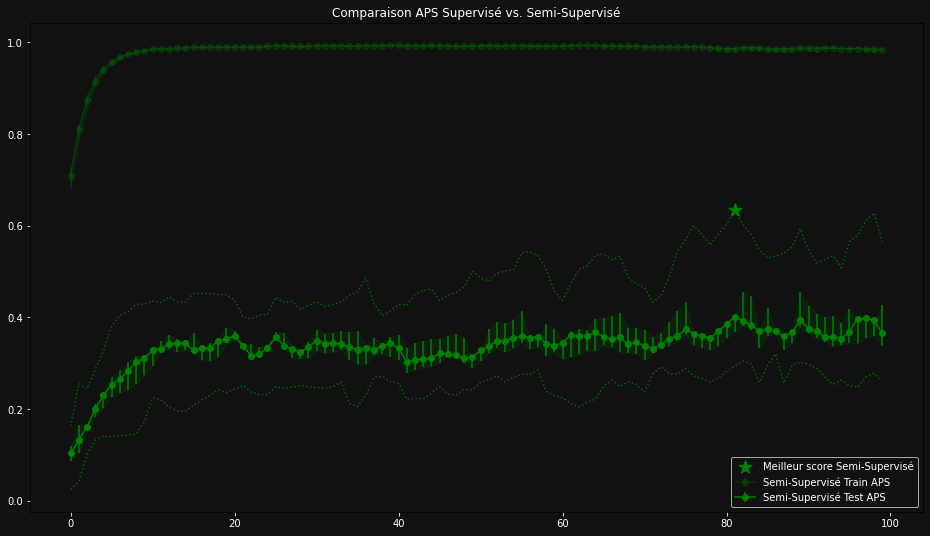

In [61]:
h_ss_train_APS = np.array([hs['APS'] for hs in training_ss_hist])
h_ss_test_APS = np.array([hs['val_APS'] for hs in training_ss_hist])

nb_epochs = np.array(h_ss_test_APS).shape[1]
print(nb_epochs, np.mean(h_ss_train_APS, axis=0).shape)
plt.figure(figsize=(16, 9))
alpha = 0.25
fmt = "-o"

train_ss_mean, train_ss_bottom_std, train_ss_top_std = top_bottom_std(h_ss_train_APS)
test_ss_mean, test_ss_bottom_std, test_ss_top_std = top_bottom_std(h_ss_test_APS)

plt.errorbar(range(nb_epochs), train_ss_mean, c="green", yerr=[train_ss_bottom_std, train_ss_top_std],label="Semi-Supervisé Train APS", alpha=alpha, fmt=fmt)
plt.errorbar(range(nb_epochs), test_ss_mean, c="green", yerr=[test_ss_bottom_std, test_ss_top_std],label="Semi-Supervisé Test APS", fmt=fmt)

plt.fill_between(range(nb_epochs), train_ss_mean + train_ss_top_std, train_ss_mean - train_ss_bottom_std, color="green", alpha=alpha/2)
plt.fill_between(range(nb_epochs), test_ss_mean + test_ss_top_std, test_ss_mean - test_ss_bottom_std, color="green", alpha=alpha/2)
# plt.plot(np.array(h_ss_test_APS).T, color="green", ls=":", alpha=alpha) # Tout
plt.plot(np.max(h_ss_test_APS, axis=0), color="green", ls=":", alpha=0.75) # min
plt.plot(np.min(h_ss_test_APS, axis=0), color="green", ls=":", alpha=0.75) # max

max_ss, e_ss = np.max(np.max(h_ss_test_APS, axis=0)), np.argmax(np.max(h_ss_test_APS, axis=0))
plt.scatter(e_ss, max_ss, label="Meilleur score Semi-Supervisé", marker='*', c='green', s=200)
plt.title("Comparaison APS Supervisé vs. Semi-Supervisé")
plt.legend()
# plt.ylim([0.85, 0.94])
plt.show()


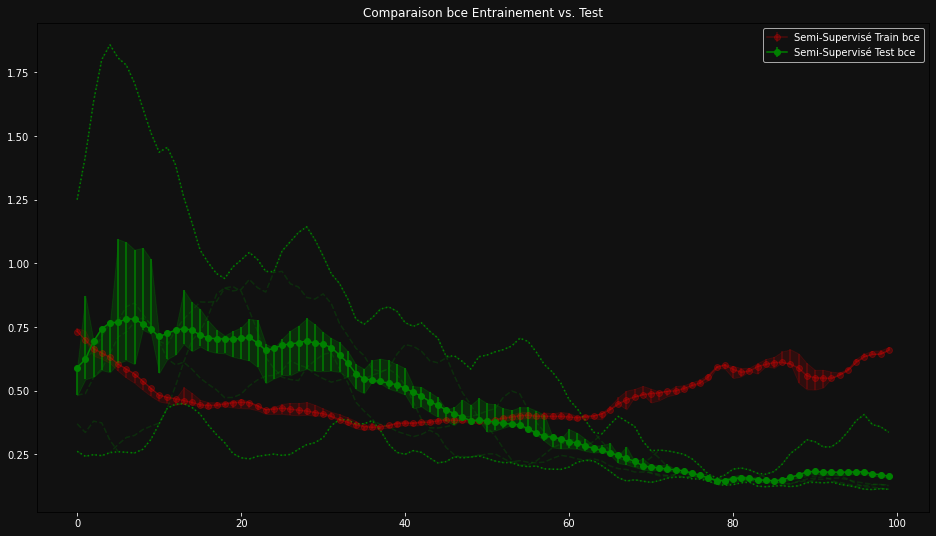

In [62]:
train_color, test_color = "red", "green"
metric = 'bce'

h_ss_train = np.array([hs[metric] for hs in training_ss_hist])
h_ss_test = np.array([hs['val_'+metric] for hs in training_ss_hist])

train_ss_mean, train_ss_bottom_std, train_ss_top_std = top_bottom_std(h_ss_train)
test_ss_mean, test_ss_bottom_std, test_ss_top_std = top_bottom_std(h_ss_test)

plt.figure(figsize=(16, 9))
fmt = "-o"

plt.errorbar(range(len(train_ss_mean)), train_ss_mean, c=train_color, yerr=[train_ss_bottom_std, train_ss_top_std],label="Semi-Supervisé Train "+metric, alpha=alpha, fmt=fmt)
plt.errorbar(range(len(test_ss_mean)), test_ss_mean, c=test_color, yerr=[test_ss_bottom_std, test_ss_top_std],label="Semi-Supervisé Test "+metric, fmt=fmt)

plt.fill_between(range(len(train_ss_mean)), train_ss_mean-train_ss_bottom_std, train_ss_mean+train_ss_top_std, color=train_color, alpha=alpha/2)
plt.fill_between(range(len(test_ss_mean)), test_ss_mean-test_ss_bottom_std, test_ss_mean+test_ss_top_std, color=test_color, alpha=alpha)

plt.plot(np.array(h_ss_test).T, color=test_color, ls="--", alpha=0.25)
plt.plot(np.max(h_ss_test, axis=0), color=test_color, ls=":", alpha=1)
plt.plot(np.min(h_ss_test, axis=0), color=test_color, ls=":", alpha=1)

plt.title("Comparaison " + metric + " Entrainement vs. Test")
plt.legend()
# plt.ylim([0.85, 0.94])

plt.show()

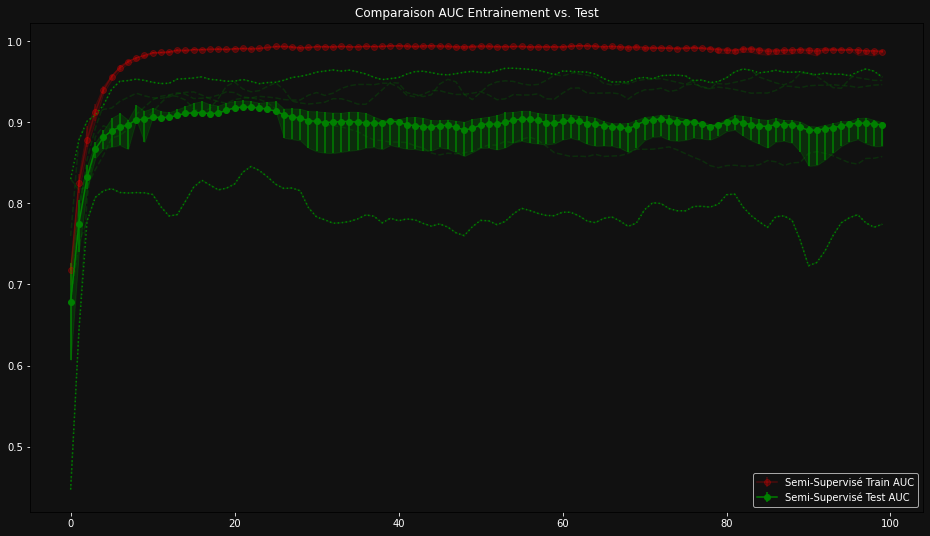

In [63]:
train_color, test_color = "red", "green"
metric = 'AUC'

h_ss_train = np.array([hs[metric] for hs in training_ss_hist])
h_ss_test = np.array([hs['val_'+metric] for hs in training_ss_hist])

train_ss_mean, train_ss_bottom_std, train_ss_top_std = top_bottom_std(h_ss_train)
test_ss_mean, test_ss_bottom_std, test_ss_top_std = top_bottom_std(h_ss_test)

plt.figure(figsize=(16, 9))
fmt = "-o"

plt.errorbar(range(len(train_ss_mean)), train_ss_mean, c=train_color, yerr=[train_ss_bottom_std, train_ss_top_std],label="Semi-Supervisé Train "+metric, alpha=alpha, fmt=fmt)
plt.errorbar(range(len(test_ss_mean)), test_ss_mean, c=test_color, yerr=[test_ss_bottom_std, test_ss_top_std],label="Semi-Supervisé Test "+metric, fmt=fmt)

plt.fill_between(range(len(train_ss_mean)), train_ss_mean-train_ss_bottom_std, train_ss_mean+train_ss_top_std, color=train_color, alpha=alpha/2)
plt.fill_between(range(len(test_ss_mean)), test_ss_mean-test_ss_bottom_std, test_ss_mean+test_ss_top_std, color=test_color, alpha=alpha)

plt.plot(np.array(h_ss_test).T, color=test_color, ls="--", alpha=0.25)
plt.plot(np.max(h_ss_test, axis=0), color=test_color, ls=":", alpha=1)
plt.plot(np.min(h_ss_test, axis=0), color=test_color, ls=":", alpha=1)

plt.title("Comparaison " + metric + " Entrainement vs. Test")
plt.legend()
# plt.ylim([0.85, 0.94])

plt.show()

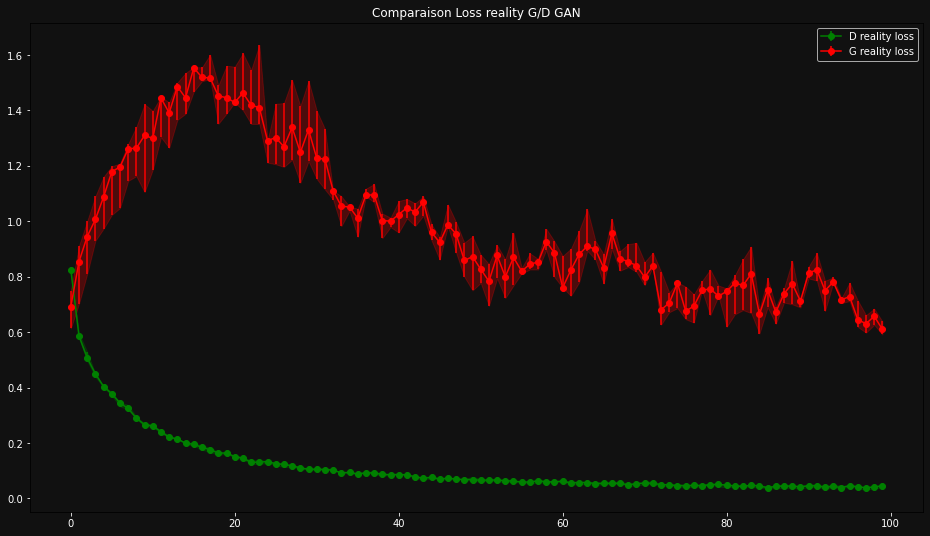

In [64]:
G_color, D_color = "red", "green"

G_loss = np.array([hs["G_Reality_loss"] for hs in training_ss_hist])
D_loss = np.array([hs["D_Reality_loss"] for hs in training_ss_hist])

G_loss_mean, G_loss_bottom_std, G_loss_top_std = top_bottom_std(G_loss)
D_loss_mean, D_loss_bottom_std, D_loss_top_std = top_bottom_std(D_loss)

plt.figure(figsize=(16, 9))
fmt = "-o"
alpha = 0.25
plt.errorbar(range(len(D_loss_mean)), D_loss_mean, c=D_color, yerr=[D_loss_bottom_std, D_loss_top_std], label="D reality loss", fmt=fmt)
plt.errorbar(range(len(G_loss_mean)), G_loss_mean, c=G_color, yerr=[G_loss_bottom_std, G_loss_top_std], label="G reality loss", fmt=fmt)

plt.fill_between(range(len(D_loss_mean)), D_loss_mean-D_loss_bottom_std, D_loss_mean+D_loss_top_std, color=D_color, alpha=alpha)
plt.fill_between(range(len(G_loss_mean)), G_loss_mean-G_loss_bottom_std, G_loss_mean+G_loss_top_std, color=G_color, alpha=alpha)

plt.title("Comparaison Loss reality G/D GAN")
plt.legend()
# plt.ylim([0.85, 0.94])

plt.show()

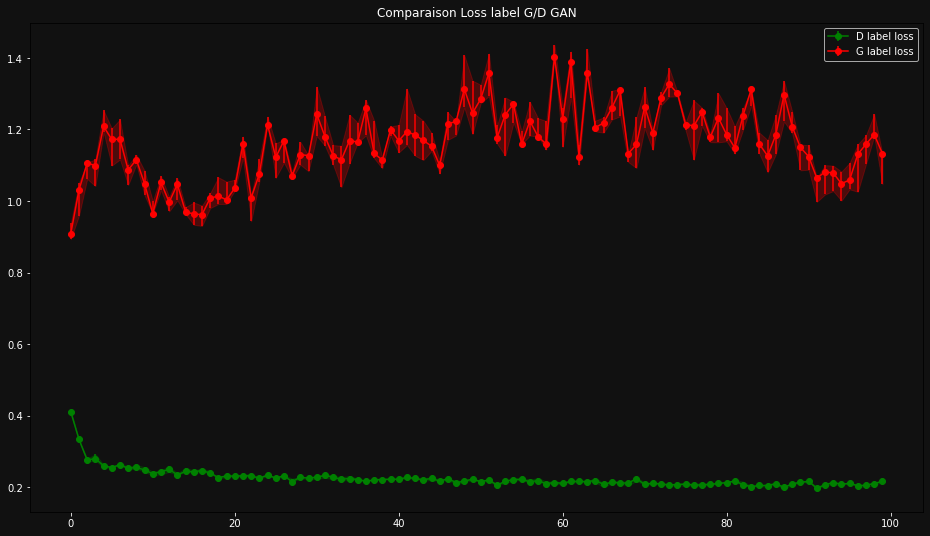

In [65]:
G_color, D_color = "red", "green"

G_loss = np.array([hs["G_Label_loss"] for hs in training_ss_hist])
D_loss = np.array([hs["D_Label_loss"] for hs in training_ss_hist])

G_loss_mean, G_loss_bottom_std, G_loss_top_std = top_bottom_std(G_loss)
D_loss_mean, D_loss_bottom_std, D_loss_top_std = top_bottom_std(D_loss)

plt.figure(figsize=(16, 9))
fmt = "-o"
alpha = 0.25
plt.errorbar(range(len(D_loss_mean)), D_loss_mean, c=D_color, yerr=[D_loss_bottom_std, D_loss_top_std], label="D label loss", fmt=fmt)
plt.errorbar(range(len(G_loss_mean)), G_loss_mean, c=G_color, yerr=[G_loss_bottom_std, G_loss_top_std], label="G label loss", fmt=fmt)

plt.fill_between(range(len(D_loss_mean)), D_loss_mean-D_loss_bottom_std, D_loss_mean+D_loss_top_std, color=D_color, alpha=alpha)
plt.fill_between(range(len(G_loss_mean)), G_loss_mean-G_loss_bottom_std, G_loss_mean+G_loss_top_std, color=G_color, alpha=alpha)

plt.title("Comparaison Loss label G/D GAN")
plt.legend()
# plt.ylim([0.85, 0.94])

plt.show()

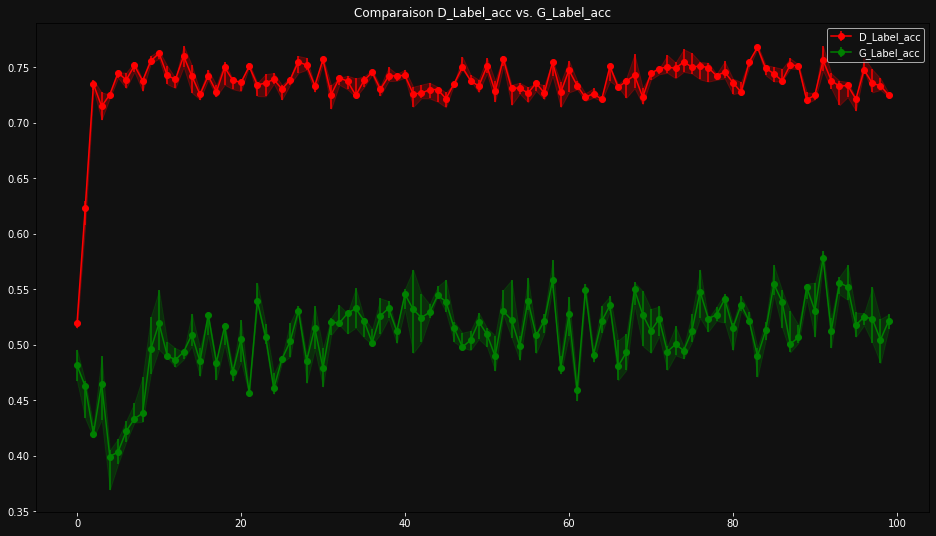

In [66]:
l1_name, l1_color = "D_Label_acc", "red"
l2_name, l2_color = "G_Label_acc", "green"

l1 = np.array([hs[l1_name] for hs in training_ss_hist])
l2 = np.array([hs[l2_name] for hs in training_ss_hist])

l1_mean, l1_bottom_std, l1_top_std = top_bottom_std(l1)
l2_mean, l2_bottom_std, l2_top_std = top_bottom_std(l2)

plt.figure(figsize=(16, 9))
fmt = "-o"
alpha = 0.25
plt.errorbar(range(len(l1_mean)), l1_mean, c=l1_color, yerr=[l1_bottom_std, l1_top_std], label=l1_name, fmt=fmt)
plt.errorbar(range(len(l2_mean)), l2_mean, c=l2_color, yerr=[l2_bottom_std, l2_top_std], label=l2_name, fmt=fmt)

plt.fill_between(range(len(l1_mean)), l1_mean-l1_bottom_std, l1_mean+l1_top_std, color=l1_color, alpha=alpha)
plt.fill_between(range(len(l2_mean)), l2_mean-l2_bottom_std, l2_mean+l2_top_std, color=l2_color, alpha=alpha)

plt.title(f"Comparaison {l1_name} vs. {l2_name}")
plt.legend()

plt.show()

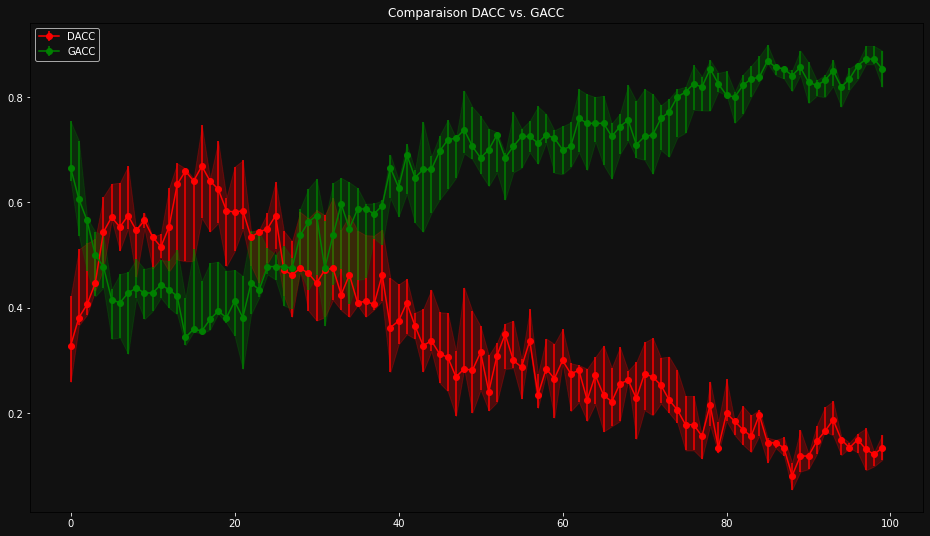

In [67]:
l1_name, l1_color = "DACC", "red"
l2_name, l2_color = "GACC", "green"

l1 = np.array([hs[l1_name] for hs in training_ss_hist])
l2 = np.array([hs[l2_name] for hs in training_ss_hist])

l1_mean, l1_bottom_std, l1_top_std = top_bottom_std(l1)
l2_mean, l2_bottom_std, l2_top_std = top_bottom_std(l2)

plt.figure(figsize=(16, 9))
fmt = "-o"
alpha = 0.25
plt.errorbar(range(len(l1_mean)), l1_mean, c=l1_color, yerr=[l1_bottom_std, l1_top_std], label=l1_name, fmt=fmt)
plt.errorbar(range(len(l2_mean)), l2_mean, c=l2_color, yerr=[l2_bottom_std, l2_top_std], label=l2_name, fmt=fmt)

plt.fill_between(range(len(l1_mean)), l1_mean-l1_bottom_std, l1_mean+l1_top_std, color=l1_color, alpha=alpha)
plt.fill_between(range(len(l2_mean)), l2_mean-l2_bottom_std, l2_mean+l2_top_std, color=l2_color, alpha=alpha)

plt.title(f"Comparaison {l1_name} vs. {l2_name}")
plt.legend()

plt.show()

In [42]:
n_predict = 1000
reality = np.repeat(0, n_predict)
labels = np.repeat(0, n_predict)
noise = generate_noise(n_predict, latent_dim)
gx = G.predict([noise, labels])
D.evaluate(gx, [labels, reality])
print(np.unique(np.round(D.predict(gx), 0)[0], return_counts=True))
print(np.unique(np.round(D.predict(gx), 0)[1], return_counts=True))
print()
GAN.evaluate([noise, labels], [labels, reality])
print(np.unique(np.round(GAN.predict([noise, labels]), 0)[0], return_counts=True))
print(np.unique(np.round(GAN.predict([noise, labels]), 0)[1], return_counts=True))

32/32 [==============================] - 0s 4ms/step - loss: 2.8280 - Label_loss: 1.3279 - Reality_loss: 1.5001 - Label_acc: 0.0070 - Reality_acc: 0.1160
(array([0., 1.], dtype=float32), array([  7, 993], dtype=int64))
(array([0., 1.], dtype=float32), array([116, 884], dtype=int64))

32/32 [==============================] - 0s 5ms/step - loss: 0.4554 - Label_loss: 0.1075 - Reality_loss: 0.3480 - Label_acc: 0.9930 - Reality_acc: 0.8910
(array([0., 1.], dtype=float32), array([ 13, 987], dtype=int64))
(array([0., 1.], dtype=float32), array([107, 893], dtype=int64))


In [ ]:
# h = np.array(hist)

# def plot_metrics(metrics, data=pdhist, labels=None):
# 	labels = metrics if labels is None else labels
# 	fig, ax = plt.subplots(figsize=(16, 9))
# 	for m, l in zip(metrics, labels):
# 		ax.plot(data[m], label=l)
# 	ax.legend()
# 	return fig, ax


# fig, ax = plot_metrics(["loss", "val_loss"], data=pdhist)
# fig.show()

# fig, ax = plot_metrics(["AUC", "val_AUC"], data=pdhist)
# fig.show()

# fig, ax = plot_metrics(["APS", "val_APS"], data=pdhist)
# fig.show()

# fig, ax = plot_metrics(["D_loss", "G_loss"], data=pdhist)
# fig.show()


# alpha = 0.25
# plt.figure(figsize=(16, 9))
# plt.plot(pdhist[["Precision"]], label="Test Precision")
# plt.plot(pdhist[["Recall"]], label="Test Recall")
# Testf1_v = [f1_score(p, r) for p, r in zip(pdhist[["Precision"]].values, pdhist[["Recall"]].values)]
# plt.plot(Testf1_v, label="Test F1")

# plt.plot(pdhist[["val_Precision"]], label="Test Precision")
# plt.plot(pdhist[["val_Recall"]], label="Test Recall")
# Testf1_v = [f1_score(p, r) for p, r in zip(pdhist[["val_Precision"]].values, pdhist[["val_Recall"]].values)]
# plt.plot(Testf1_v, label="Test F1")
# plt.legend()
# plt.show()

In [ ]:
# thresholds = 0.5 # limite pour l'arrondissement

# y_true = sup_test[:,:1].reshape(-1, )
# y_pred_score = D.predict(sup_test[:,1:])[0].reshape(-1, )
# y_pred = np.where(y_pred_score > thresholds, 1, 0)

# print(np.unique(y_true, return_counts=True))
# print(np.unique(y_pred, return_counts=True))
# """
# Matrice de confusion  | Pred 0 | Pred 1 | Total
# 			Réalité 0 |   VN   |   FP   | de non observation dans la base
# 			Réalité 1 |   FN   |   VP   | d'observation dans la base
# """
# # https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel

# # Precision
# # = VP / (VP + FP)
# # = VP / P
# # = le taux de positif détecté par le modèle (FP étant les individu positif non détecté, VP + FP = l'ensemble des positifs de la base)
# # 100% de precision = 0 FP c-a-d que quand le model predit un individu avec la classe 1 on est sur à 100% que l'individu est bien de la classe 1

# # Recall = VP / (VP + FN) = taux de bonnes predictions parmis les prediction classé en 1 ?, 100% de recall = aucun FN

# # f1 = moyenne harmonique de Precision et Recall

# precision = tf.keras.metrics.Precision(thresholds=thresholds)(y_true, y_pred)
# recall = tf.keras.metrics.Recall(thresholds=thresholds)(y_true, y_pred)
# f1 = f1_score(precision, recall)
# AUC = tf.keras.metrics.AUC()(y_true, y_pred_score)
# confusion_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
# print(f"""
# Precision: 	{precision}
# Recall: 	{recall}
# f1_score: 	{f1}
# AUC: 		{AUC}
# Matrice de confusion:\n{confusion_matrix}
# """)

# # le but de la confusion_matrix est donc d'avoir sa diagonale avec les valeurs les plus élevé possible

# # si notre but est de ne louper aucun messages qui est une observation, on cherche à avoir un recall élevé
# # Mais on a des chances d'avoir dans nos predictions beaucoup de messages étant des FP
# # exemple avec un modèle "paranoiaque" qui predit tout le temps les message commes étant des observations:
# # on a un recall à 100% mais tout les message n'étant pas des observation sont classé comme tel, on a donc une Precision tres faible

# # L'entrainement ne suffit pas, une fois fini il faut trouver un thresholds de prediction qui satisfait nos besoins (c-a-d si l'on prefere un fort Recall ou une forte Precision)

In [ ]:
# from sklearn.metrics import roc_curve, roc_auc_score

# fpr, tpr, t = roc_curve(y_true, D.predict(sup_test[:,1:])[0].reshape(-1, ))
# plt.figure(figsize=(9, 9))
# plt.plot(fpr, tpr)
# plt.plot([0, 1], ls="--", label="")
# plt.title('ROC curve')
# plt.xlabel('false positive rate')
# plt.ylabel('true positive rate')
# plt.xlim(0,)
# plt.ylim(0,)
# plt.show()

In [ ]:
# # https://youtu.be/iCZJfO-7C5Q?t=656
# plt.figure(constrained_layout=True, figsize=(16, 9))
# x = (tpr + fpr) / 2 ** (0.5)
# y = (tpr - fpr) / 2 ** (0.5)
# plt.plot(x, y)
# plt.plot([0, max(x)], [0, 0], ls="--", label="random prediction")
# plt.title('ROC curve rotation à Pi/4')
# plt.xlabel('(TPR + FPR) / sqrt(2)')
# plt.ylabel('(TPR - FPR) / sqrt(2)')
# best_t = t[np.argmax(y)]
# # print(max(y), np.argmax(y), t, best_t)
# plt.scatter(x[np.argmax(y)], np.max(y), label=best_t, marker='*', c='red', s=200)
# plt.legend()
# plt.show()
# fpr, tpr, t = roc_curve(y_true, D.predict(sup_test[:,1:])[0].reshape(-1, ))
# t[np.argmax(tpr - fpr)], best_t

In [ ]:
# thresholds = 0.5
# y_true = sup_test[:,:1].reshape(-1, )
# y_pred_scrore = D.predict(sup_test[:,1:])[0].reshape(-1, )
# y_pred = np.where(y_pred_scrore > thresholds, 1, 0)
# precision = tf.keras.metrics.Precision(thresholds=thresholds)(y_true, y_pred)
# recall = tf.keras.metrics.Recall(thresholds=thresholds)(y_true, y_pred)
# f1 = f1_score(precision, recall)
# AUC = tf.keras.metrics.AUC()(y_true, y_pred_scrore)
# confusion_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
# print(f"""
# Threshold {thresholds}
# {np.unique(y_true, return_counts=True)}
# {np.unique(y_pred, return_counts=True)}
# Precision: 	{precision*100:.2f}%
# Recall: 	{recall*100:.2f}%
# f1_score: 	{f1*100:.2f}%
# AUC: 		{AUC*100:.2f}%
# Matrice de confusion:\n{confusion_matrix}
# """)

# lp, lr, lf = precision, recall, f1

# thresholds = best_t
# y_pred = np.where(y_pred_scrore > thresholds, 1, 0)
# precision = tf.keras.metrics.Precision(thresholds=thresholds)(y_true, y_pred)
# recall = tf.keras.metrics.Recall(thresholds=thresholds)(y_true, y_pred)
# f1 = f1_score(precision, recall)
# AUC = tf.keras.metrics.AUC()(y_true, y_pred_scrore)
# confusion_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
# print(f"""
# Threshold {thresholds}
# {np.unique(y_true, return_counts=True)}
# {np.unique(y_pred, return_counts=True)}
# Precision: 	{precision*100:.2f}% ({(precision - lp)*100:+.2f}%)
# Recall: 	{recall*100:.2f}% ({(recall - lr)*100:+.2f}%)
# f1_score: 	{f1*100:.2f}% ({(f1 - lf)*100:+.2f}%)
# AUC: 		{AUC*100:.2f}%
# Matrice de confusion:\n{confusion_matrix}
# """)

# Visualisation de l'espace de decision pendant l'entraînement semi-supervisé

In [ ]:
# from matplotlib import animation
# from matplotlib.gridspec import GridSpec
# import matplotlib
# matplotlib.rcParams['animation.embed_limit'] = 2**128


# h = np.asarray(hist)

# fig = plt.figure(constrained_layout=True, figsize=(16, 9))
# gs = GridSpec(4, 4, figure=fig)
# ax1, ax2 = fig.add_subplot(gs[0:-1, 1:-1]), fig.add_subplot(gs[-1, :])

# def animate(i):
# 	ax1.clear()
# 	# ax1.set_xlim([-1., 1.])
# 	# ax1.set_ylim([-1., 1.])
# 	for _, m in enumerate(np.unique(data[i,:,2])):
# 		d = data[:,data[i,:,2] == m]
# 		ax1.scatter(d[i,:,0], d[i,:,1], color=MapColor[d[i,:,3].astype(int)], edgecolor=MapEdgecolor[np.round(d[i,:,5]).astype(int)], alpha=d[i,:,6], marker=MapMarkers[int(m)], s=s + s * d[i,:,4], linewidths=es)
# 	ax2.clear()
# 	ax2.set_xlim([0, h.shape[0]])
# 	ax2.plot(h[:i,[0, 1]])

# ani = animation.FuncAnimation(fig, animate, frames=data.shape[0])
# plt.close()
# print("render...")
# out = HTML(ani.to_jshtml())

# out

In [ ]:
# with open('result_stable.html', 'w') as f:
# 	print("save...")
# 	f.write(out.data)

In [ ]:
# from matplotlib import animation
# from matplotlib.gridspec import GridSpec
# import matplotlib
# matplotlib.rcParams['animation.embed_limit'] = 2**128


# h = np.asarray(hist)

# fig = plt.figure(constrained_layout=True, figsize=(16, 9))
# gs = GridSpec(4, 4, figure=fig)
# ax1, ax2 = fig.add_subplot(gs[0:-1, 1:-1]), fig.add_subplot(gs[-1, :])

# def animate(i):
# 	ax1.clear()
# 	ax1.set_xlim([-1.1, 1.1])
# 	ax1.set_ylim([-1.1, 1.1])
# 	for _, m in enumerate(np.unique(data[i,:,3])):
# 		d = data[:,data[i,:,2] == m]
# 		ax1.scatter(d[i,:,0], d[i,:,1], color=MapColor[d[i,:,2].astype(int)], edgecolor=MapEdgecolor[np.round(d[i,:,4]).astype(int)], alpha=d[i,:,6], marker=MapMarkers[int(m)], s=s + s * d[i,:,5], linewidths=es)
# 	ax2.clear()
# 	ax2.set_xlim([0, h.shape[0]])
# 	ax2.plot(h[:i,[0, 1]])

# ani = animation.FuncAnimation(fig, animate, frames=data.shape[0])
# plt.close()
# print("render...")
# out = HTML(ani.to_jshtml())

# # with open('result2.html', 'w') as f:
# # 	print("save...")
# # 	f.write(out.data)

# out

In [ ]:
# from matplotlib import animation
# from matplotlib.gridspec import GridSpec
# import matplotlib
# matplotlib.rcParams['animation.embed_limit'] = 2**128

# # 0 = x
# # 1 = y
# # 2 = true_label
# # 3 = true_reality
# # 4 = pred_label
# # 5 = pred_reality
# # 6 = alpha

# h = np.asarray(hist)

# fig = plt.figure(constrained_layout=True, figsize=(16, 9))
# gs = GridSpec(4, 4, figure=fig)
# ax1, ax2 = fig.add_subplot(gs[0:-1, 1:-1]), fig.add_subplot(gs[-1, :])

# def animate(i):
# 	ax1.clear()
# 	# ax1.set_xlim([-1.1, 1.1])
# 	# ax1.set_ylim([-1.1, 1.1])
# 	d = data[:,data[i,:,3] == 1]
# 	ax1.scatter(d[i,:,0], d[i,:,1], color=MapColor[d[i,:,2].astype(int)], edgecolor=MapEdgecolor[np.round(d[i,:,4]).astype(int)], alpha=d[i,:,6],s=s, linewidths=es)
# 	ax2.clear()
# 	ax2.set_xlim([0, h.shape[0]])
# 	ax2.plot(h[:i,[0, 1]])

# ani = animation.FuncAnimation(fig, animate, frames=data.shape[0])
# plt.close()
# print("render...")
# out = HTML(ani.to_jshtml())

# out

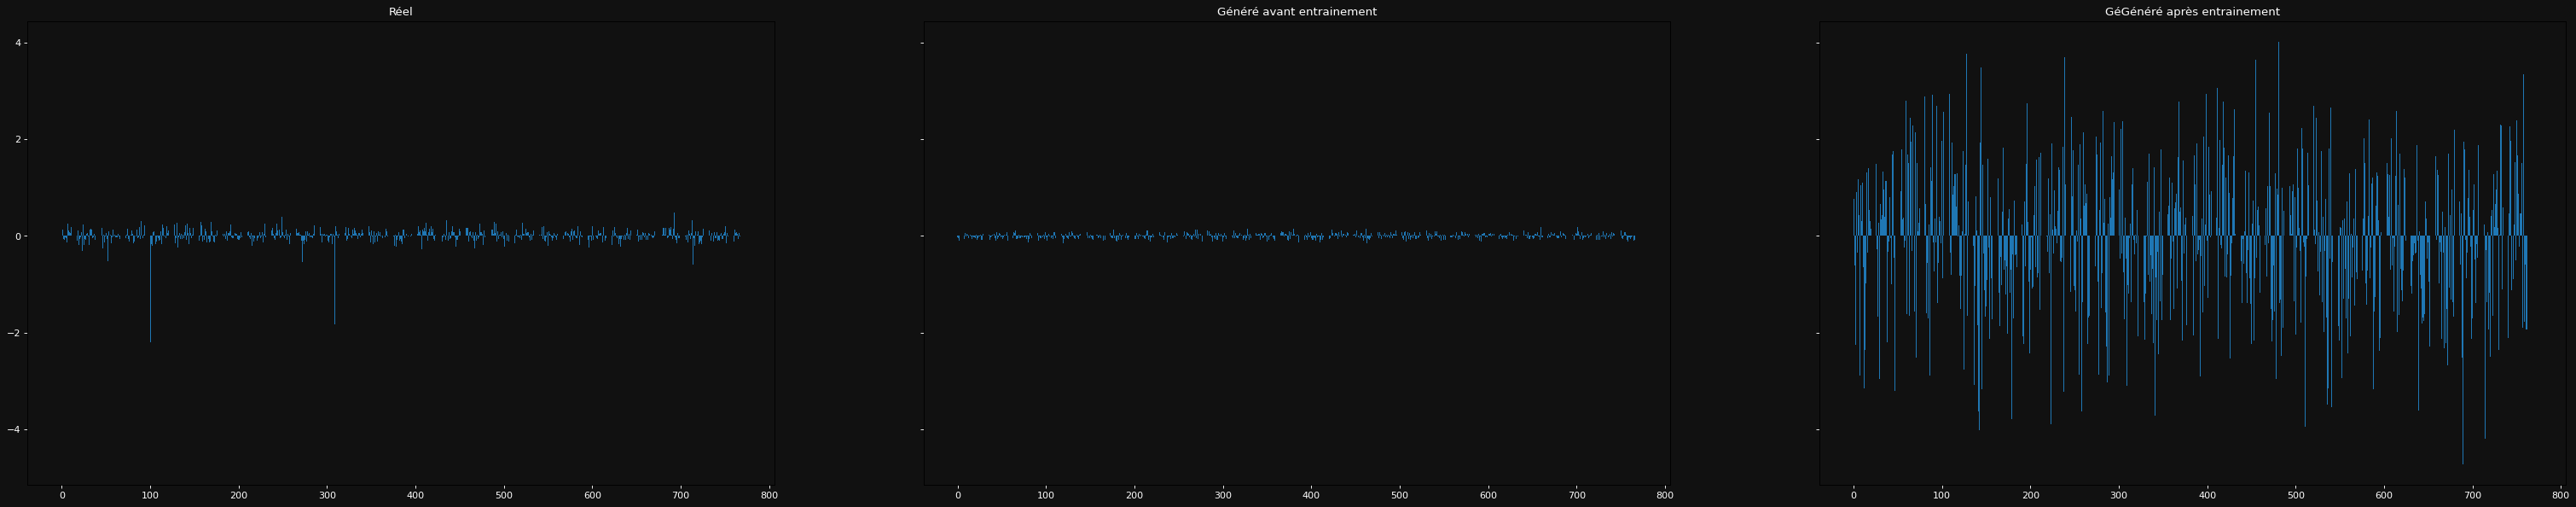

In [68]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16*3, 9), dpi=80)
pred_apres = G.predict([n, l])
axs[0].bar(range(768), sup[20,1:])
axs[0].set(title='Réel')
axs[1].bar(range(768), pred_avant[0])
axs[1].set(title='Généré avant entrainement')
axs[2].bar(range(768), pred_apres[0])
axs[2].set(title='GéGénéré après entrainement')
plt.show()

In [ ]:
# l = np.repeat(1, 100).reshape((-1, 1))
# n = generate_noise(100, latent_dim)
# w = 16 * 2
# h = 9
# dpi = 100
# fig, axs = plt.subplots(1, 2, sharey=True, figsize=(w, h), dpi=dpi)
# pred_apres = G.predict([n, l])

# axs[0].bar(range(768), np.mean(sup[:,1:], axis=0))
# axs[0].set(title='Moyenne par composants des vecteurs réels')
# axs[1].bar(range(768), np.mean(pred_apres, axis=0))
# axs[1].set(title='Moyenne par composants des vecteurs généré après entrainement')
# plt.show()

# fig, axs = plt.subplots(1, 2, sharey=True, figsize=(w, h), dpi=dpi)
# axs[0].bar(range(768), np.std(sup[:,1:], axis=0))
# axs[0].set(title='Ecart type des vecteurs réels')
# axs[1].bar(range(768), np.std(pred_apres, axis=0))
# axs[1].set(title='Ecart type des vecteurs généré après entrainement')
# plt.show()

# fig, axs = plt.subplots(1, 2, sharey=True, figsize=(w, h), dpi=dpi)
# axs[0].bar(range(768), np.max(sup[:,1:], axis=0))
# axs[0].set(title='Max des composants des vecteurs réels')
# axs[1].bar(range(768), np.max(pred_apres, axis=0))
# axs[1].set(title='Max des composants des vecteurs généré après entrainement')
# plt.show()

# fig, axs = plt.subplots(1, 2, sharey=True, figsize=(w, h), dpi=dpi)
# axs[0].bar(range(768), np.min(sup[:,1:], axis=0))
# axs[0].set(title='Min descomposants des vecteur réels')
# axs[1].bar(range(768), np.min(pred_apres, axis=0))
# axs[1].set(title='Min descomposants des vecteurs généré après entrainement')
# plt.show()

# Partie SUPERVISE

## Entraînement

In [69]:
from tensorflow.keras.metrics import *

tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

verbose = 0

# n_Fold = 4
# n_batch = 17
# D_lr = 0.001
# epochs = 50

print(f"""
n_Fold 	=   {n_Fold}
n_batch =   {n_batch}
lr      =   {D_lr}
epochs 	=   {epochs}
""")
varbose = 0
k_fold = StratifiedKFold(n_splits=n_Fold)
X, y = sup_train[:, 1:], sup_train[:, :1]
hist_supervise = []
for step, (train_index, test_index) in enumerate(k_fold.split(X, y)):
	print(step)

	(_, _, D_L_only, _), _, _ = creation_models(competition=competition, lrs=(D_lr, G_lr)) # Remise à 0 des models à chaque fold
	D_L_only.trainable = True
	
	test = np.concatenate([y[test_index], X[test_index]], axis=1)
	test = np.concatenate([test, sup_test_surplus], axis=0) # ajout du surplus d'observations

	x_test, y_test = test[:, 1:], test[:, :1]
	x_train, y_train = X[train_index], y[train_index]

	train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
	train_dataset = train_dataset.batch(n_batch)

	validation_batch_size = y_test.shape[0]
	# print(validation_batch_size)
	
	D_L_only.trainable = True
	D_L_only.compile(loss="bce", metrics=["bce", "mse", AUC(name="AUC"), APS], optimizer=tf.keras.optimizers.Adam(learning_rate=D_lr))
	history_s = D_L_only.fit(train_dataset, validation_data=[x_test, y_test], epochs=epochs, batch_size=n_batch, verbose=varbose, shuffle=False, validation_batch_size=validation_batch_size)
	hist_supervise.append(history_s.history)
print("done.")


n_Fold 	=   5
n_batch =   64
lr      =   0.001
epochs 	=   100

0
1
2
3
4
done.


In [46]:
def plot_resume(metric, ax, alpha=0.25, ylim=None, errorbar=True, fill_between=True, display_train=True, plot_max=True):
	s_color, ss_color = "red", "green"
	
	h_s_train = [hs[metric] for hs in hist_supervise]
	h_s_test = [hs['val_'+metric] for hs in hist_supervise]

	h_ss_train = np.array([hs[metric] for hs in training_ss_hist])
	h_ss_test = np.array([hs['val_'+metric] for hs in training_ss_hist])

	train_s_mean, train_s_bottom_std, train_s_top_std = top_bottom_std(h_s_train)
	test_s_mean, test_s_bottom_std, test_s_top_std = top_bottom_std(h_s_test)

	train_ss_mean, train_ss_bottom_std, train_ss_top_std = top_bottom_std(h_ss_train)
	test_ss_mean, test_ss_bottom_std, test_ss_top_std = top_bottom_std(h_ss_test)

	# if(subplot is not None):
	# 	# plt.subplot(subplot)

	fmt = "-o"

	if(errorbar):
		if(display_train):
			ax.errorbar(range(len(train_s_mean)), train_s_mean, c=s_color, yerr=[train_s_bottom_std, train_s_top_std],label="Supervisé Train"+metric, alpha=alpha, fmt=fmt)
			ax.errorbar(range(len(train_ss_mean)), train_ss_mean, c=ss_color, yerr=[train_ss_bottom_std, train_ss_top_std],label="Semi-Supervisé Train"+metric, alpha=alpha, fmt=fmt)
		
		ax.errorbar(range(len(test_s_mean)), test_s_mean, c=s_color, yerr=[test_s_bottom_std, test_s_top_std],label="Supervisé Test"+metric, fmt=fmt)
		ax.errorbar(range(len(test_ss_mean)), test_ss_mean, c=ss_color, yerr=[test_ss_bottom_std, test_ss_top_std],label="Semi-Supervisé Test"+metric, fmt=fmt)
	
	if(fill_between):
		if(display_train):
			ax.fill_between(range(len(train_s_mean)), train_s_mean-train_s_bottom_std, train_s_mean+train_s_top_std, color=s_color, alpha=alpha/2)
			ax.fill_between(range(len(train_ss_mean)), train_ss_mean-train_ss_bottom_std, train_ss_mean+train_ss_top_std, color=ss_color, alpha=alpha/2)
		ax.fill_between(range(len(test_s_mean)), test_s_mean-test_s_bottom_std, test_s_mean+test_s_top_std, color=s_color, alpha=alpha/2)
		ax.fill_between(range(len(test_ss_mean)), test_ss_mean-test_ss_bottom_std, test_ss_mean+test_ss_top_std, color=ss_color, alpha=alpha/2)

	# print('='*150)
	if(plot_max):
		# ax.plot(np.array(h_s_test).T, color=s_color, ls=":", alpha=alpha)
		ax.plot(np.max(h_s_test, axis=0), color=s_color, ls=":", alpha=alpha)
		ax.plot(np.min(h_s_test, axis=0), color=s_color, ls=":", alpha=alpha)

		# ax.plot(np.array(h_ss_test).T, color=s_color, ls=":", alpha=alpha)
		ax.plot(np.max(h_ss_test, axis=0), color=ss_color, ls=":", alpha=alpha)
		ax.plot(np.min(h_ss_test, axis=0), color=ss_color, ls=":", alpha=alpha)

		max_ss, e_ss = np.max(h_ss_test), np.argmax(np.max(h_ss_test, axis=0))
		max_s, e_s = np.max(h_s_test), np.argmax(np.max(h_s_test, axis=0))
		ax.scatter(e_ss, max_ss, label="Meilleur score Semi-Supervisé", marker='*', c=ss_color, s=200)
		ax.scatter(e_s, max_s, label="Meilleur score Supervisé", marker='*', c=s_color, s=200)

		# print(f"""
		# Résumé de la métrique {metric} :
		# Max {metric} Semi-Supervisé: {round(max_ss, 3)} (epoch: {e_ss})
		# Max {metric} Supervisé:      {round(max_s, 3)} (epoch: {e_s})

		# Semi-Supervisé: {(max_ss-max_s)*100:+.2f}%
		# """)
	
	ax.set_title("Comparaison " + metric + " Supervisé vs. Semi-Supervisé")
	ax.legend()
	if(ylim is not None):
		ax.set_ylim(bottom=ylim)
	# plt.show()
	# print('='*75)

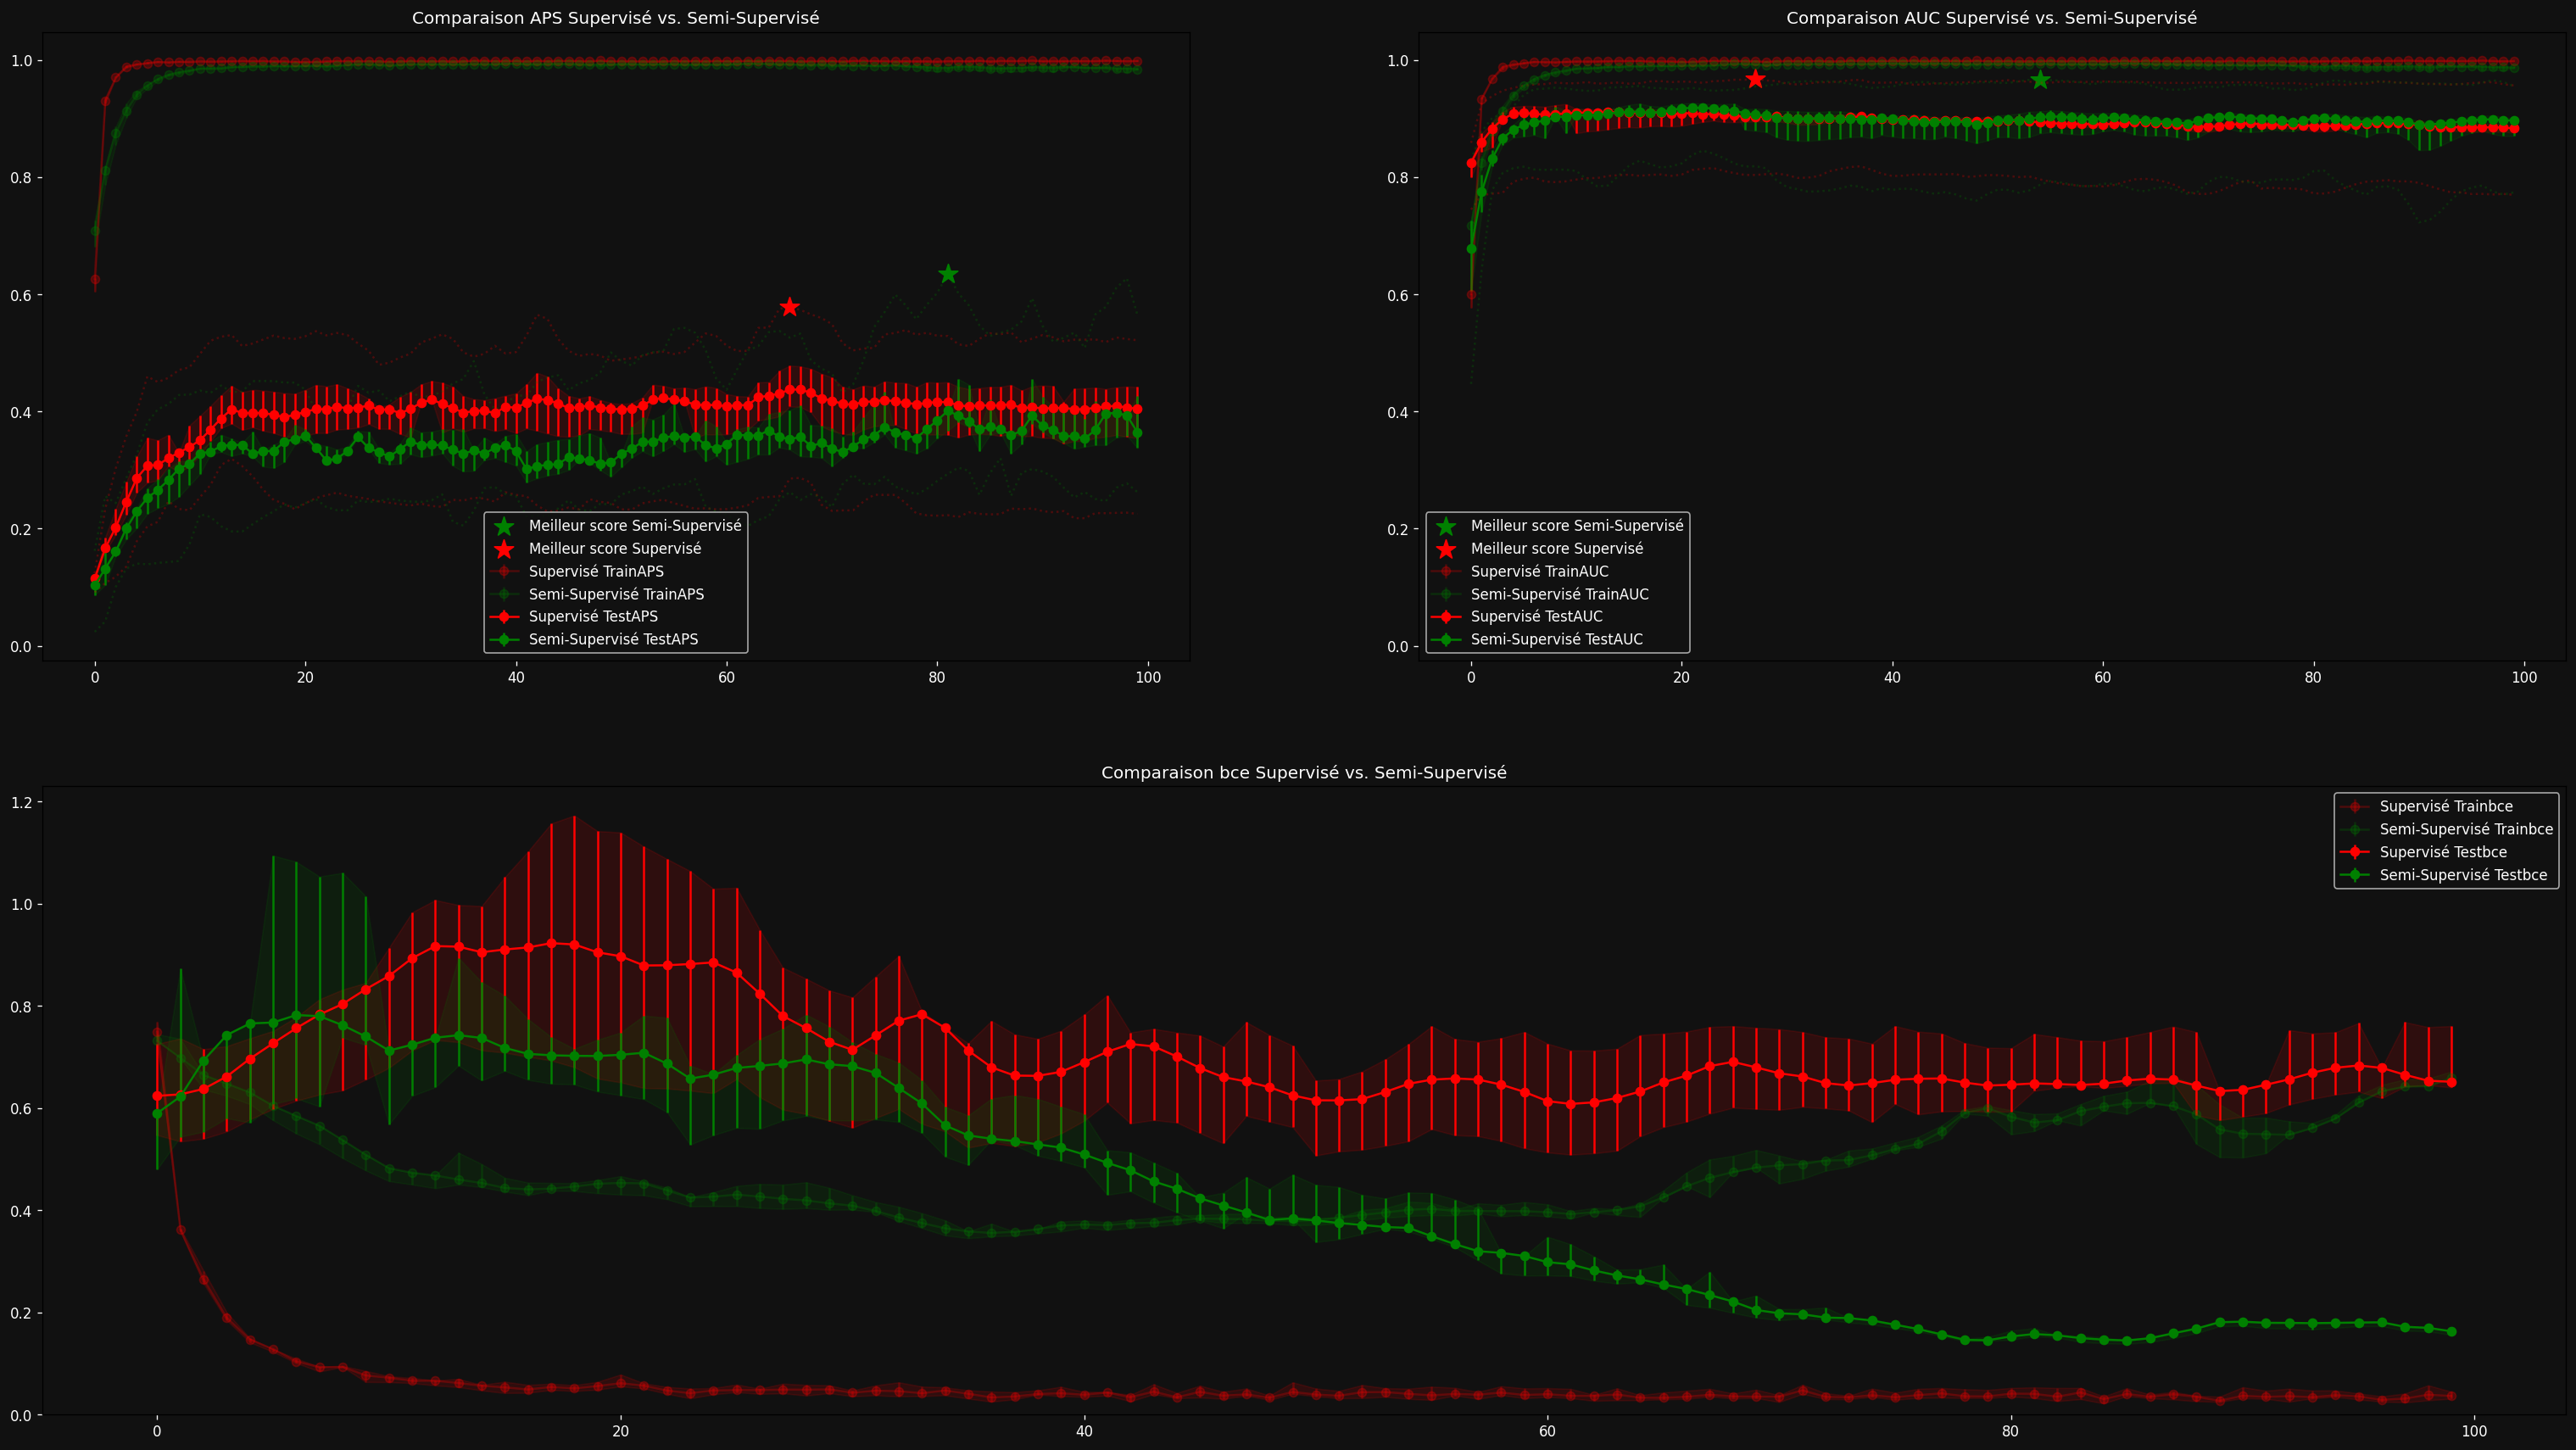

In [71]:
errorbar = True
fill_between = True
display_train = True

scale=2
plt.figure(figsize=(16*scale, 9*scale), dpi=120)
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)
plot_resume("APS", ax1, errorbar=errorbar, fill_between=fill_between, display_train=display_train)
plot_resume("AUC", ax2, errorbar=errorbar, fill_between=fill_between, display_train=display_train)
plot_resume("bce", ax3, errorbar=errorbar, ylim=0, fill_between=fill_between, display_train=True, plot_max=False)
ax2.sharey(ax1)
plt.show()


In [ ]:
errorbar = True
fill_between = True
display_train = True
plot_resume("APS", errorbar=errorbar, fill_between=fill_between, display_train=display_train)
plot_resume("AUC", errorbar=errorbar, fill_between=fill_between, display_train=display_train)
plot_resume("Precision", errorbar=errorbar, fill_between=fill_between, display_train=display_train)
plot_resume("Recall", errorbar=errorbar, fill_between=fill_between, display_train=display_train)
plot_resume("loss", errorbar=errorbar, fill_between=fill_between, display_train=True, plot_max=False)

In [318]:
# np.save(f"SS_{e}_{n}_({dl}_{dl})", training_ss_hist)
# np.save(f"S_{e}_{n}_({dl}_{dl})", hist_supervise)

In [321]:
# training_ss_hist = np.load("training_ss_hist.npy", allow_pickle=True)
# hist_supervise = np.load("hist_supervise.npy", allow_pickle=True)
training_ss_hist = np.load("SS_50_32_(0.0002_0.0002).npy", allow_pickle=True)
hist_supervise = np.load("S_50_32_(0.0002_0.0002).npy", allow_pickle=True)

In [ ]:
errorbar = True
fill_between = True
display_train = True
plot_resume("APS", errorbar=errorbar, fill_between=fill_between, display_train=display_train)
plot_resume("AUC", errorbar=errorbar, fill_between=fill_between, display_train=display_train)
plot_resume("Precision", errorbar=errorbar, fill_between=fill_between, display_train=display_train)
plot_resume("Recall", errorbar=errorbar, fill_between=fill_between, display_train=display_train)
plot_resume("loss", errorbar=errorbar, fill_between=fill_between, display_train=True, plot_max=False)

In [ ]:
G_color, D_color = "red", "green"

D_loss = np.array([hs["D_Reality_loss"] for hs in training_ss_hist])
G_loss = np.array([hs["d_R_only_loss"] for hs in training_ss_hist])

G_loss_mean, G_loss_bottom_std, G_loss_top_std = top_bottom_std(G_loss)
D_loss_mean, D_loss_bottom_std, D_loss_top_std = top_bottom_std(D_loss)

plt.figure(figsize=(16, 9))
fmt = "-o"
alpha = 0.25
plt.errorbar(range(len(D_loss_mean)), D_loss_mean, c=D_color, yerr=[D_loss_bottom_std, D_loss_top_std], label="D_Reality_loss", fmt=fmt)
plt.errorbar(range(len(G_loss_mean)), G_loss_mean, c=G_color, yerr=[G_loss_bottom_std, G_loss_top_std], label="d_R_only_loss", fmt=fmt)

plt.fill_between(range(len(D_loss_mean)), D_loss_mean-D_loss_bottom_std, D_loss_mean+D_loss_top_std, color=D_color, alpha=alpha)
plt.fill_between(range(len(G_loss_mean)), G_loss_mean-G_loss_bottom_std, G_loss_mean+G_loss_top_std, color=G_color, alpha=alpha)

plt.title("Comparaison Loss label G/D GAN")
plt.legend()
# plt.ylim([0.85, 0.94])

plt.show()

In [ ]:
training_ss_hist[0].keys()

In [ ]:


# thresholds = 0.5 # limite pour l'arrondissement

# y_true = sup_test[:,:1].reshape(-1, )
# y_pred_score = D_lonly.predict(sup_test[:,1:]).reshape(-1, )
# y_pred = np.where(y_pred_score > thresholds, 1, 0)

# print(np.unique(y_true, return_counts=True))
# print(np.unique(y_pred, return_counts=True))
# """
# Matrice de confusion  | Pred 0 | Pred 1 | Total
# 			Réalité 0 |   VN   |   FP   | de non observation dans la base
# 			Réalité 1 |   FN   |   VP   | d'observation dans la base
# """
# # https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel

# # Precision
# # = VP / (VP + FP)
# # = VP / P
# # = le taux de positif détecté par le modèle (FP étant les individu positif non détecté, VP + FP = l'ensemble des positifs de la base)
# # 100% de precision = 0 FP c-a-d que quand le model predit un individu avec la classe 1 on est sur à 100% que l'individu est bien de la classe 1

# # Recall = VP / (VP + FN) = taux de bonnes predictions parmis les prediction classé en 1 ?, 100% de recall = aucun FN

# # f1 = moyenne harmonique de Precision et Recall

# precision = tf.keras.metrics.Precision(thresholds=thresholds)(y_true, y_pred)
# recall = tf.keras.metrics.Recall(thresholds=thresholds)(y_true, y_pred)
# f1 = f1_score(precision, recall)
# AUC = tf.keras.metrics.AUC()(y_true, y_pred_score)
# confusion_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
# print(f"""
# Precision: 	{precision}
# Recall: 	{recall}
# f1_score: 	{f1}
# AUC: 		{AUC}
# Matrice de confusion:\n{confusion_matrix}
# """)

# # le but de la confusion_matrix est donc d'avoir sa diagonale avec les valeurs les plus élevé possible

# # si notre but est de ne louper aucun messages qui est une observation, on cherche à avoir un recall élevé
# # Mais on a des chances d'avoir dans nos predictions beaucoup de messages étant des FP
# # exemple avec un modèle "paranoiaque" qui predit tout le temps les message commes étant des observations:
# # on a un recall à 100% mais tout les message n'étant pas des observation sont classé comme tel, on a donc une Precision tres faible

# # L'entrainement ne suffit pas, une fois fini il faut trouver un thresholds de prediction qui satisfait nos besoins (c-a-d si l'on prefere un fort Recall ou une forte Precision)